**NOMS I COGNOMS: ANTONIO TIGRI VALDIVIA & ANDREU VALL HERNÀNDEZ** 

**GRUP DE LABORATORI: F**

# Anàlisi exploratòria de dades i preprocessament 

L'**anàlisi exploratòria de dades** és el tractament estadístic al qual se sotmeten les mostres recollides durant un procés de recerca en qualsevol camp científic. 
Per a major rapidesa i precisió, tot el procés sol realitzar-se per mitjans informàtics, amb aplicacions específiques per al tractament estadístic.

### Aplicació a la Mineria de Dades

A la **mineria de dades**, si bé no és obligatori, és una bona pràctica analitzar les dades amb què treballarem per tal d'observar-ne les característiques principals per tal de tenir una idea de l'estructura del conjunt de dades, identificar la variable objectiu i possibles tècniques de modelatge.

**Procés bàsic**
- *Transformar les dades*: Ens serveix per saber què fer front a valors nuls, faltants o dades atípiques. A més destablir si hi ha necessitat de reduir la dimensionalitat de dades.
- *Visualitzar*: Utilitzar alguna eina per fer una representació gràfica de les dades, per exemple, R, Jupyter notebook, Google Colab, etc.
- *Analitzar i interpretar*: Analitzar i interpretar les dades a través de diferents visualitzacions.
- *Documentar*: Documentar totes les gràfiques i estadístiques generades.

Aquest procés ens és útil també en revisar la descripció de les dades per comprendre què significa cada característica.

Hi ha diverses activitats en fer una anàlisi exploratòria de dades però quant a la mineria de dades els punts clau que s'han de realitzar són:

- Descripció de l'estructura de les dades.
- Identificació de dades mancants.# ¿Com ha afectat la covid a l'ús dels taxis a Nova York? 
- Detecció de valors atípics.
- Identificació de relacions entre parells variables.

Si realitzem correctament els passos ens facilitarem la manera d'abordar aquestes dades sense deixar de banda l'objectiu o el propòsit per al qual les necessitem.

L'**objectiu d'aquesta pràctica** és aprendre com fer una explicació de dades. En aquest cas utilitzarem les dades dels **taxis grocs de la ciutat de Nova York**.

En finalitzar el notebook, haureu de ser capaços de respondre la pregunta següent:


## ¿Com ha afectat la covid a l'ús dels taxis a Nova York? 

Algunes de les preguntes que ens farem al llarg del notebook són:
- Com ha canviat la covid l'ús dels taxis a NYC?
- Quina distribució d'encàrrecs segueixen els taxis i quina distància / durada tenen?
- Quines són les zones on m'és / menys taxis s'agafen? I a on més va la gent?
- Quins horaris són els més usuals?
- Quins dies de la setmana i del mes s'utilitzen més? Possibles motius?

**Instal·lació i importació de les llibreries necessàries**

In [1]:
! pip install pyarrow
! pip install pyshp
! pip install shapely
! pip install descartes

In [1]:
# Importació de les llibreries
import pandas as pd
import numpy as np
import urllib.request
import zipfile
import os
from tqdm.notebook import tqdm
import pyarrow.parquet as pq

In [2]:
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Variables globals
YEARS = [2019, 2020, 2021]

Primer de tot cal descarregar les dades:

https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [4]:
# Download the Trip Record Data
for year in tqdm(YEARS):
    if not os.path.exists(f'data/{year}'):
        os.makedirs(f'data/{year}', exist_ok=True)
        for month in tqdm(range(1, 13)): 
            urllib.request.urlretrieve( \
                f'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{year}-{month:02d}.parquet', f'data/{year}/{month:02d}.parquet')

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

## 01. Neteja de dades

Per tal de tenir unes dades netes i útils, cal eliminar totes aquelles files que continguin informació corrupta:
- La recollida és després que la finalització del trajecte.
- Les dades s'importen per mes i any. Les dates són correctes?
- Viatges amb 0 passatges?
- Viatges molts llargs o molt curts?
- Pagaments negatius.

**Data Dictionary**

De totes les columnes que tenen les dades, només calen les següents:

- *tpep_pickup_datetime*: The date and time when the meter was engaged.
- *tpep_dropoff_datetime*: The date and time when the meter was disengaged. 
- *Passenger_count*: The number of passengers in the vehicle. (This is a driver-entered value)
- *Trip_distance*: The elapsed trip distance in miles reported by the taximeter.
- *PULocationID*: TLC Taxi Zone in which the taximeter was engaged
- *DOLocationID*: TLC Taxi Zone in which the taximeter was disengaged
- *Payment_type*: A numeric code signifying how the passenger paid for the trip. 
    - 1= Credit card
    - 2= Cash
    - 3= No charge
    - 4= Dispute
    - 5= Unknown
    - 6= Voided trip
- *Fare_amount*: The time-and-distance fare calculated by the meter.
- *Total_amount*: The total amount charged to passengers. Does not include cash tips.

**Observacions:**

- Per agilitzar els càlculs i reduir el temps de còmput, feu un sampleig uniforme de les dades.
- Datatime columns són to_datetime series (ajuda per buscar les funcions)

In [4]:
def load_table(year, month):
    """
    Funció que llegeix les dades descarregades i les converteix a un DataFrame
    """
    return pq.read_table(f'data/{year}/{str(month).zfill(2)}.parquet').to_pandas()

In [5]:
required_data = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'PULocationID', \
    'DOLocationID', 'payment_type', 'fare_amount', 'total_amount']

def clean_data(data : pd.DataFrame, year, month, sampling_ratio=.05):
    """
    Funció que neteja les dades per un mes donat.
    """

    # Reduirem la taula a les columnes que ens interessa analitzar
    data = data[required_data].copy()

    # Primer per fer possible comparar les dates les passarem de string a un tipus date
    for col in ['tpep_pickup_datetime', 'tpep_dropoff_datetime']:
        data[col] = pd.to_datetime(data[col])

    # Eliminarem els viatges amb dates que no coincideixin amb l'any i mes de la taula a la que pertanyen
    invalid_pickup_date = (data['tpep_pickup_datetime'].dt.year!=year) | (data['tpep_pickup_datetime'].dt.month!=month)
    invalid_dropoff_date = (data['tpep_dropoff_datetime'].dt.year!=year) | (data['tpep_dropoff_datetime'].dt.month!=month)

    # Eliminarem els viatges sense passatgers
    null_passengers = (data['passenger_count'] == 0) | data['passenger_count'].isna()

    '''
    Eliminarem els viatges en els que la distància sigui menor a 300 metres o major a 30km.
    Pel primer hem valorat que un viatge de tant poca distància és molt poc convencional i
    pel segon hem tingut en compte quants kilòmetres fan falta per recórrer el perímetre de
    manhattan. A més, hem analitzat els percentils per acabar de confirmar quin és el punt
    on els viatges poc convencionals són suficientment escassos com per poder eliminar-los
    sense perdre informació vital.
    '''
    invalid_distance = (data['trip_distance'] < 0.3) | (data['trip_distance'] > 30)

    # Eliminarem els viatges on el taxi ha viatjat al passat
    invalid_pickup_dropoff_times = data['tpep_pickup_datetime'] > data['tpep_dropoff_datetime']

    # També els que durin més de 10 hores (hi ha especialment un munt de viatges de 24h,
    # probablement significa que la hora és correcta però la data està 1 dia off)
    invalid_duration = (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']) > pd.Timedelta(10, 'h')

    '''
    Eliminarem els viatges amb pagaments de valor negatiu i els viatges amb pagaments de valors
    desorbitats. Com abans, per tenir una idea d'on traçar la línia hem utilitzat els percentils.
    També hem analitzat quan solen ser cars els viatges i coincideixen amb els viatges molt llargs,
    que de totes maneres han sigut eliminats, o viatges amb costs addicionals sense sentit (propines de Bill Gates?)
    '''
    invalid_fare = (data['total_amount'] < 0) | (data['total_amount'] > 500)

    # Juntarem totes les condicions en una sola variable per no haver d'iterar
    invalid_data = invalid_pickup_date | invalid_dropoff_date | null_passengers | invalid_distance | \
                   invalid_pickup_dropoff_times | invalid_duration | invalid_fare

    # Fem el drop de les dades invàlides
    data.drop(invalid_data[invalid_data==True].index, inplace=True)

    # Eliminarem per últim les dades amb nan en alguna de les columnes
    data.dropna(inplace=True)

    # Per últim retornarem el dataframe
    return data.sample(round(data.shape[0] * sampling_ratio))

In [6]:
df = pd.concat([clean_data(load_table(year, month), year, month) for year in tqdm(YEARS) for month in tqdm(range(1, 13), leave=False)])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [7]:
df.to_parquet('data/taxi_data_reduced.parquet')

# Start Execution Here

In [1]:
# Importació de les llibreries
import pandas as pd
import numpy as np
import urllib.request
import zipfile
import os
from tqdm.notebook import tqdm
import pyarrow.parquet as pq

import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# Variables globals
YEARS = [2019, 2020, 2021]

df = pd.read_parquet('data/taxi_data_reduced.parquet')

A la funció *post_processing* podeu afegir tota aquesta informació que necessiteu sobre les dades per tal de dur a terme l'exploració necessària.

In [2]:
def post_processing(data):
    """
    Funció on implementar qualsevol tipus de postprocessament necessari.
    """

    # Columnes usades a partir de l'apartat 2
    data['year'] = data['tpep_pickup_datetime'].dt.year
    data['month'] = data['tpep_pickup_datetime'].dt.month
    data['year-month'] = data['year'].astype('str') + '-' + data['month'].astype('str').str.zfill(2)

    # Columnes usades a partir de l'apartat 3
    data['pickup_hour'] = data['tpep_pickup_datetime'].dt.hour
    data['pickup_day'] = data['tpep_pickup_datetime'].dt.dayofweek
    data['pickup_week'] = data['tpep_pickup_datetime'].dt.week
    data['pickup_month'] = data['tpep_pickup_datetime'].dt.month

    # Columnes usades a partir de l'apartat 4
    data['pickup_dayofyear'] = data['tpep_pickup_datetime'].dt.day_of_year
    # Duració del viatge en minuts
    data['trip_duration'] = (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).dt.total_seconds() / 60

    # En milles / hora
    data['speed'] = data['trip_distance'] / (data['trip_duration'] / 60)

    return data

Crea un nou dataset que contingui tota la informació dels anys: 2019, 2020, 2021.

Recordeu que per tal de reduir la memòria necessària, podeu agafar un subsample de dades.

In [3]:
df = post_processing(df)
df.shape

C:\Users\ANDREU~1\AppData\Local\Temp/ipykernel_14240/1104586829.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data['pickup_week'] = data['tpep_pickup_datetime'].dt.week


(6565905, 19)

## 02. Visualitzacions per anys

### Número total sobre quantitat de viatges

Podem respondre directament la pregunta: **¿Ha incrementat / disminuït la covid la quantitat de viatges fets amb taxis?**

Per respondre aquesta pregunta creu una figura de barres on es visualitzin la quantitat de viatges per any.

In [13]:
def bar_plot(df, column, xlabel, ylabel, title):
    """
    Funció que crea una figura de barres a partir del dataframe i la columna que conté la informació
    """
    
    '''
    Agrupem el dataframe pel nombre de columnes desitjades i tot
    seguit obtenim el tamany per així extreure el nombre de dades
    que tenen cada valor de la columna escollida a "column"
    '''
    data = df.groupby(column).size()
    
    # Utilitzarem el gràfic de barres de seaborn ja que és el més fàcil de implementar de forma llegible
    sns.barplot(x=data.index, y=data)
    
    # Afegim els títols i etiquetes al gràfic
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

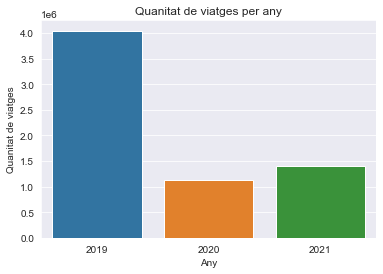

In [14]:
bar_plot(df, 'year', 'Any', 'Quanitat de viatges', 'Quanitat de viatges per any')

**Pregunta: És el comportament que esperàveu? Per què?**

Sí, donat que el març de 2020 hi va haver un confinament global i en conseqüència el nombre de viatges en taxi a NY es va veure afectat, cosa que queda plasmada en la gràfica. En el 2021 veiem una lleugera recuperació, ja que s'han anat relaxant les mesures del covid.

Ara, visualitzarem **quants passatgers hi ha per taxi i per any**.

Crea una figura amb tres subfigures (una per any) on es pugui veure el recompte de passatgers per any.

Després repetiu el mateix gràfic visualitzant el % (utilitzeu el paràmetre *norm*).

In [15]:
def passengers_taxi_year(df, xlabel, ylabel, title, norm = False):
    """
    Funció que visualitza quants passatgers hi ha per taxi i per any
    """

    # Creem la figura on posarem els 3 gràfics (un per cada any)
    fig, axs = plt.subplots(ncols=3, figsize=(21, 8))

    ylim = 0

    # Iterarem pels 3 anys per a mostrar cada gràfic a la figura
    for i, year in enumerate(YEARS):

        '''
        Agruper per els mesos de l'any de la iteració actual i fem
        la suma dels valors de la columna "passenger_count", obtenint
        així el nombre de passatgers totals per mes
        '''
        data = df[df['year']==year].groupby('month')['passenger_count'].sum()

        # Canviem el format de dades a percentatge en funció del paràmetre "norm"
        if norm:
            data = 100 * data / data.sum()
        
        # Utilitzarem el gràfic de barres de seaborn ja que és el més fàcil de implementar de forma llegible
        sns.barplot(x=data.index, y=data, ax=axs[i], palette='crest')
        ylim = max(ylim, data.max())
        
        # Afegim els títols i etiquetes al gràfic
        axs[i].title.set_text(title + f' ({year})')
        axs[i].set(xlabel=xlabel)
        axs[i].set(ylabel=ylabel)
    
    for ax in axs:
        ax.set(ylim=(0, ylim))

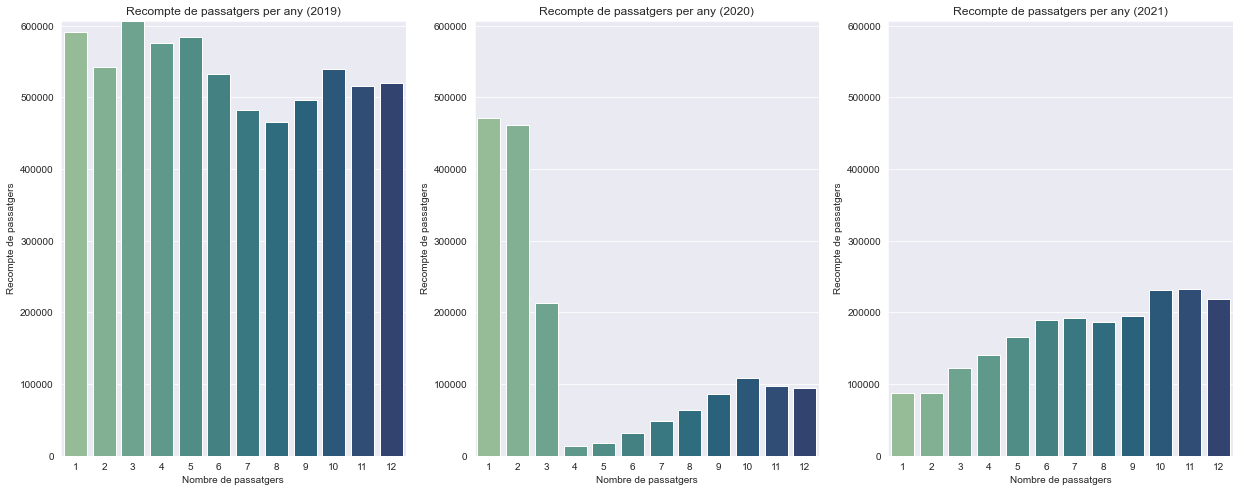

In [16]:
passengers_taxi_year(df, 'Nombre de passatgers', 'Recompte de passatgers', 'Recompte de passatgers per any')

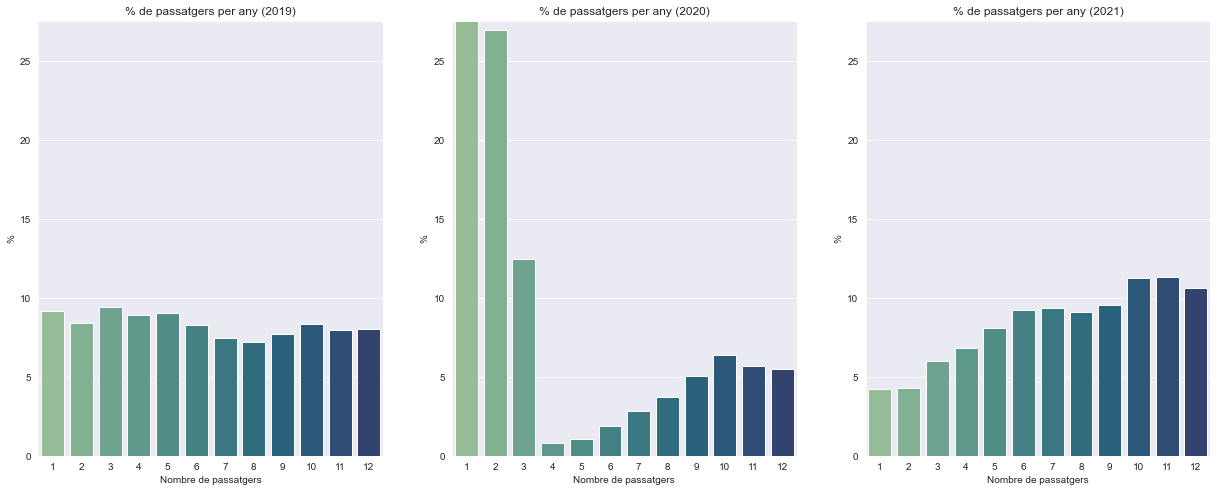

In [17]:
passengers_taxi_year(df, 'Nombre de passatgers', '%', '% de passatgers per any', norm=True)

A la figura anterior hem visualitzat cada any per separat. Per tal que la visualització sigui més ràpida i simple d'interpretar, uniu tota la informació en un gràfic.

Després repetiu el mateix gràfic visualitzant el % (utilitzeu el paràmetre *norm*).

In [33]:
def passengers_taxi(df, xlabel, ylabel, norm=False):
    """
    Funció que visualitza quants passatgers hi ha per taxi
    """

    '''
    Per tenir tot en un sol gràfic necessitarem agrupar per
    parelles unificades (és a dir, que el mes contingui de
    forma directa l'any al que pertany) i procedirem com abans
    '''
    data = df.groupby('year-month')['passenger_count'].sum()

    # Canviem el format de dades a percentatge en funció del paràmetre "norm"
    if norm:
        data = 100 * data / data.sum()

    # Creem la figura on anirà el gràfic, establint el tamany i l'angle de els elements de l'eix x
    plt.figure(figsize=(21, 8))
    plt.xticks(rotation=45)

    # Creem el gràfic de barres com en cel·les anteriors
    sns.barplot(x=data.index, y=data, palette='crest')

    # Afegim els títols i etiquetes
    title = 'Percentage' if norm else 'Count'
    plt.title(f'Passenger {title} by Month')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

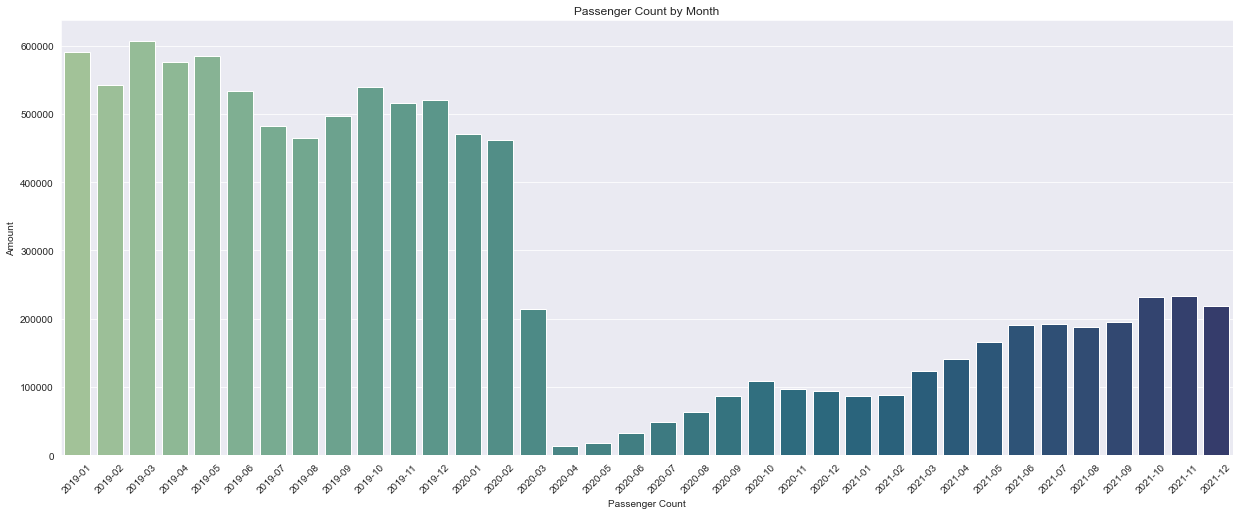

In [34]:
passengers_taxi(df, 'Passenger Count', 'Amount')

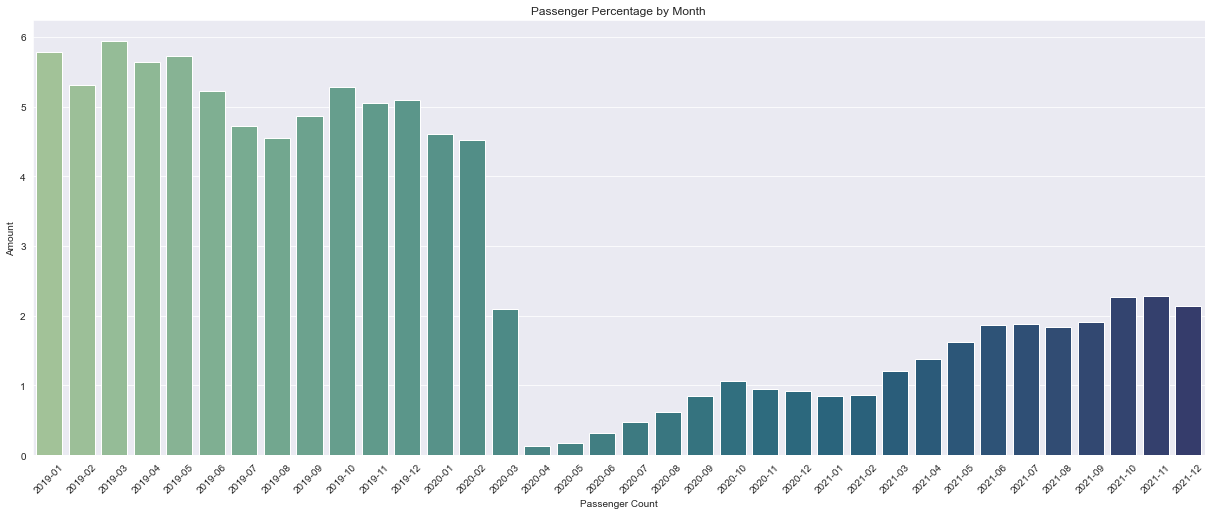

In [20]:
passengers_taxi(df, 'Passenger Count', 'Amount', norm=True)

**Pregunta: Quin impacte heu vist sobre les dades? Creieu que la covid va tenir molt impacte?**

El març del 2020 es van reduir els viatges a la meitat respecte els mesos anterior, i a partir de l'abril es redueix enormement. Això és degut a que el confinament va començar aproximadament a la meitat del març, i per tant va tenir un impacte molt important (es redueix a menys d'un 5% dels viatges que hi havia fins el moment). A partir de llavors el nombre de viatges va tornar a créixer lentament però fins el final del 2021 la quantitat de viatges no ha arribat a la meitat de viatges que hi havia fins abans de la pandèmia. 

## 03. Quantitat de viatges

Fins ara hem vist la quantitat de viatges que hi ha hagut en els anys estudiats.

Anem a estudiar quins canvis es poden veure si agreguem les dades per hores, dies de la setmana, setmana de l'any i mes.

Aquests gràfics han de ser de línies discontínues i marcar amb una rodona o creu allà on està el valor

In [31]:
def visualize_trips(df, columns, title, xlabel, ylabel):
    """
    Funció que visualitza els viatges per diferents agregacions de dades
    """
    
    '''
    Com no creiem que utilitzar la dropoff_hour ens doni molta
    informació, ja que els viatges no haurien de tenir una durada
    suficientment llarga com per poder extreure conclusions de la
    columna, utilitzarem només la data de recollida de la persona
    del viatge. Per obtenir-ne el conteig usarem el paràmetre size
    '''
    data = df.groupby(columns[0]).size()

    # Creem la figura on hi haurà el gràfic i establim el tamany
    plt.figure(figsize=(21, 6))

    # Posem el títol i les etiquetes
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Creem el gràfic amb els paràmetres desitjats
    plt.plot(data.index, data, marker='o', linestyle='dashed')

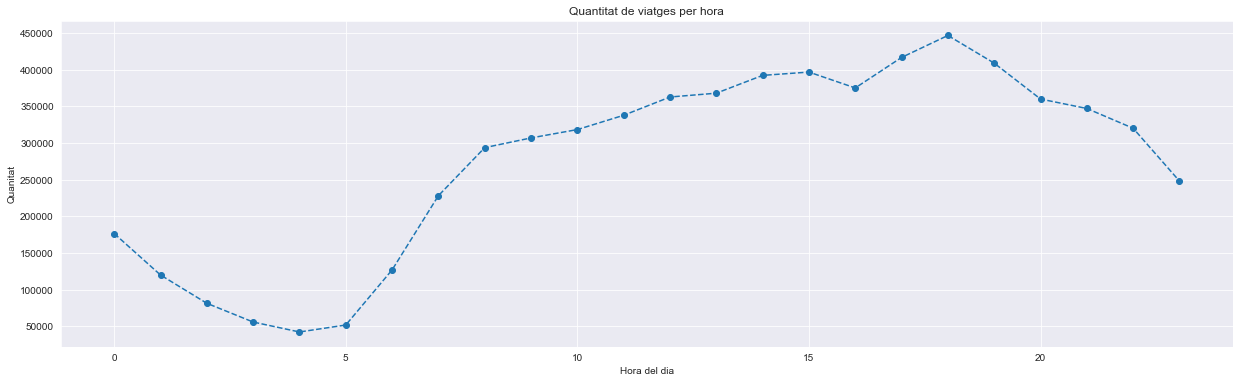

In [27]:
visualize_trips(df, ['pickup_hour', 'dropoff_hour'], title = 'Quantitat de viatges per hora', xlabel = 'Hora del dia', ylabel = 'Quanitat')

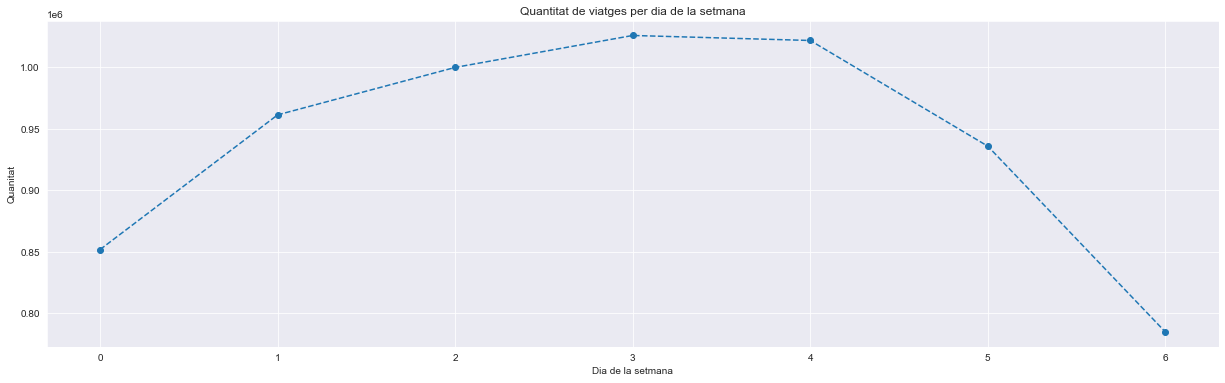

In [32]:
visualize_trips(df, ['pickup_day', 'dropoff_day'], title = 'Quantitat de viatges per dia de la setmana', xlabel = 'Dia de la setmana', ylabel = 'Quanitat')

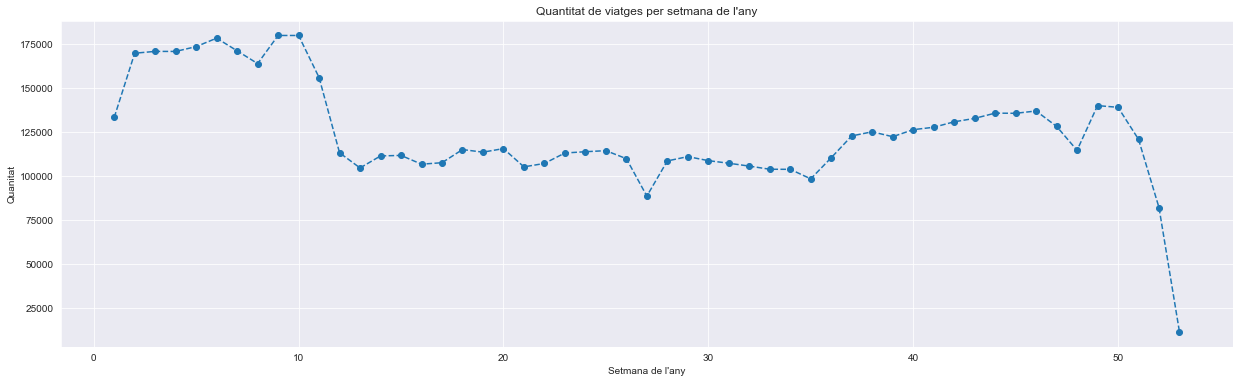

In [25]:
visualize_trips(df, ['pickup_week', 'dropoff_week'], title = 'Quantitat de viatges per setmana de l\'any', xlabel = 'Setmana de l\'any', ylabel = 'Quanitat')

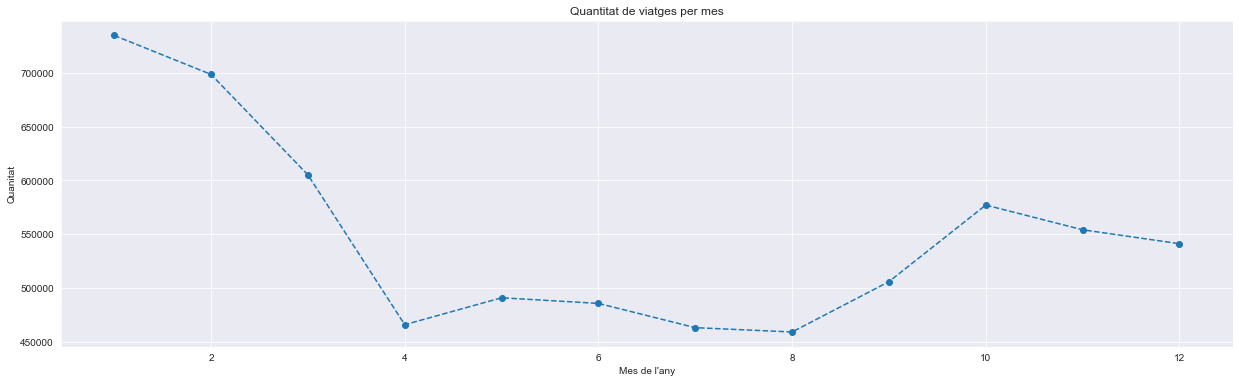

In [26]:
visualize_trips(df, ['pickup_month', 'dropoff_month'], title = 'Quantitat de viatges per mes', xlabel = 'Mes de l\'any', ylabel = 'Quanitat')

**Pregunta: Quins comportaments veieu en cada cas? Quin creieu que és el motiu?**

Hora -> Normalment la gent agafa taxis durant el dia, amb un pic a la tarda (les hores normals de finalització de la jornada laboral)
Dia -> 
Setmana -> Les 2 últimes setmanes hi ha signficativament menys viatges, perquè probablement és nadal i a més la majoria dels anys no tenen la última setmana. També es veu que les primeres 10 setmanes tenen més viatges, ja que el 10 març de l'any 2020 hi va haver una caiguda important en el nº viatges
Mesos -> Similar a les setmanes, es veu la caiguda del covid de mes 2 al 4. L'increment en els últims mesos pot ser degut a la recuperació de viatges del 2021 post pandèmia.

## 04. Relació distancia - temps i velocitat

A les dades tenim la distància que ha recorregut el taxi en cada viatge i de la informació temporal podem extreure també la duració d'aquest.


Intentarem esbrinar com la covid va afectar les distàncies i les durades dels viatges juntament amb la velocitat dels taxis.

Creieu que la densitat de trànsit va variar?

### Histogrames

Per començar visualitza els **histogrames** de distància i durada per any.

Pots fer servir la funció *plt.hist()* o *plt.bar()*.

In [8]:
def visualize_histograms(df, column, title, xlabel, ylabel, xlim):
    """
    Funció que crea un histograma a partir de la informació que conté la columna del dataframe
    """

    # Creem la figura on aniran els 3 histogrames (un per any)
    fig, axs = plt.subplots(ncols=3, figsize=(21, 8))

    # Perquè el gràfic es vegi correctament farem 20 bins
    nbins = 10
    ylim = 0

    # Iterem per a crear els 3 histogrames
    for i, year in enumerate(YEARS):

        # Establirem el rang del bin a partir de l'xlim i el nombre de bins fent la divisió
        bin_width = xlim[1] / nbins

        '''
        Agafem les dades establint el xlim abans de muntar el gràfic, per a la millor visualització d'aquest
        tot seguit fem divisió entera i producte perl bin_width per a agrupar totes les dades en el mateix
        bin. Fem el value counts per obtenir la quantitat de viatges en el bin que hem muntat.
        '''
        data = (df.loc[(df['year']==year) & (df[column] < xlim[1]), column] // bin_width * bin_width).value_counts()

        # Transformem en percentatge les dades, ja que així podrem veure més fàcilment la informació que ens interessa
        data = 100 * data / data.sum()

        sns.barplot(x=data.index, y=data, ax=axs[i])

        # Afegim els títols i etiquetes al gràfic
        axs[i].title.set_text(title + f' ({year})')
        axs[i].set(xlabel=xlabel)
        axs[i].set(ylabel=ylabel)

        # Agafem el màxim de les dades per escalar els 3 histogrames
        ylim = max(ylim, data.max())

    for ax in axs:
        ax.set(ylim=(0, ylim))

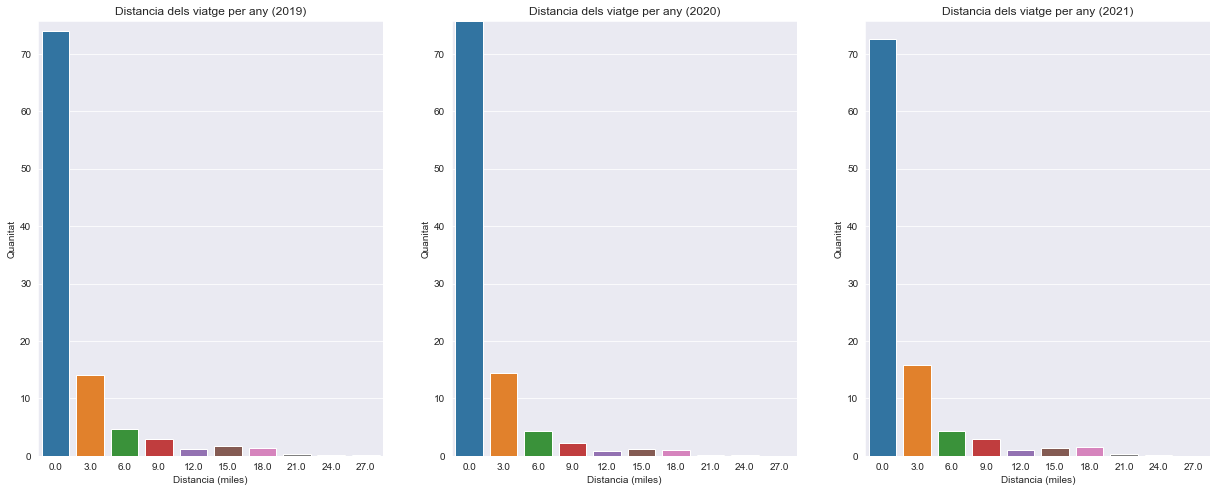

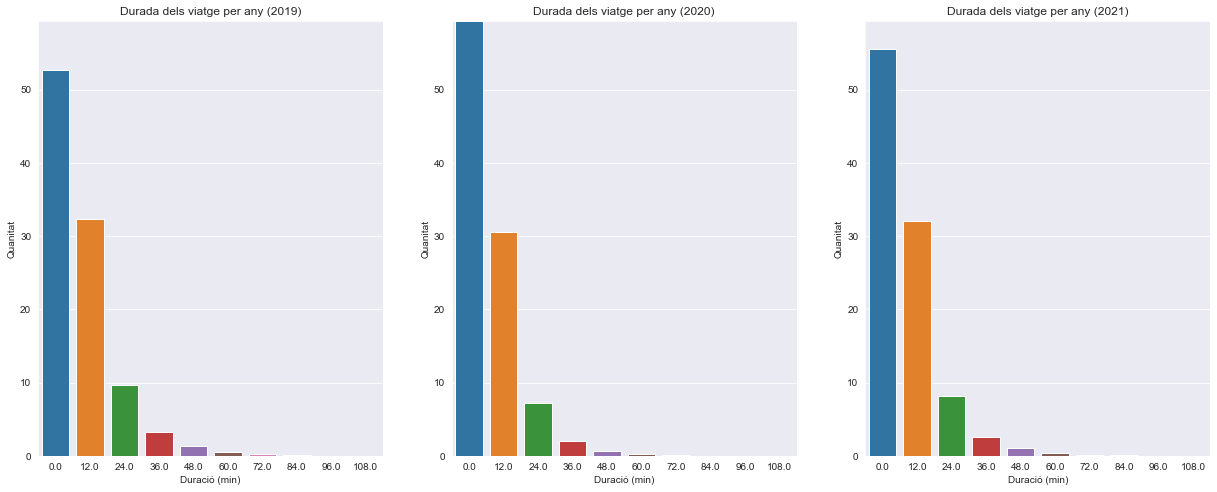

In [9]:
# Vam decidir tallar els viatges més grans que 30 milles, per tant tallarem el gràfic a 30 milles
# La columna trip_distance era originalment en milles i preferim no canviar-la
visualize_histograms(df, 'trip_distance', title = 'Distancia dels viatge per any',
                     xlabel = 'Distancia (miles)', ylabel = 'Quanitat', xlim = (-5, 30))

# I tallarem les hores 2 hores, ja que tallant en 10 hores el gràfic pràcticament no mostra res útil
# (gairebé tots els viatges tenen menys de 1 hora de durada)
visualize_histograms(df, 'trip_duration', title = 'Durada dels viatge per any', 
                     xlabel = 'Duració (min)', ylabel = 'Quanitat', xlim = (-1, 120))

**PREGUNTES:** 

* Com creieu que la covid va afectar les distàncies i durades dels viatges?

* I a la velocitat dels taxis?

> ANSWER
Podem apreciar que el covid va afectar lleugerament a la durada dels viatges, probablement degut a una reducció en el tràfic producte del confinament. Pel que fa a la distància, no hi ha molt de canvi que es pugui notar. Bé és cert que durant 2020 va haver un percentatge més gran de viatges curts, però això podria ser coincidència deguda al sampling. Si haguessim de pensar en una raó relacioanda al covid, podria ser que hi hagi menys viatges llargs degut al control de la mobilitat durant el confinament. Evidentment, en general, com els temps es redueixen i v = d/t, la velocitat dels taxis ha augmentat lleugerament degut al covid (tot i que si la quantitat de viatges curts és molt més gran en relació al llargs, això podria cancel·lar-se. En el següent apartat s'explora això en profunditat.

### Gràfic de dispersió i correlació

Crea gràfics de dispersió per il·lustrar la relació entre la durada i la distància dels viatges.

Es possible que les dades continguin mostres fora la distribució (outliers). En aquest cas, omet aquestes dades i torna a visualitzar el grafic.

Per veure si existeix alguna correlació, es interesant que utilitzeu la funció *sns.regplot()*.

In [36]:
def scatter_plot(df, x_value, y_value, xlabel, ylabel, remove_outliers = False):
    """
    Funció que mostra un scatter plot donades dues dades
    """

    # Creem la figura on aniran els 3 histogrames (un per any)
    fig, axs = plt.subplots(ncols=3, figsize=(21, 9))

    # Iterem per a crear els 3 histogrames
    for i, year in enumerate(YEARS):

        # Guardem la part del dataframe corresponent a l'any de la iteració actual
        df_year = df[df['year']==year]

        # Creem un scatterplot amb els valors x,y
        sns.scatterplot(x=df_year[x_value], y=df_year[y_value], ax=axs[i])

        '''
        Fem un sample de 50.000 viatges aleatoris, ja que si no tarda moltíssim en fer la regressió lineal,
        i 50.000 viatges és una xifra prou significativa (diferents execucions donen rectes similars)
        '''
        df_reduced = df_year.sample(50_000)

        '''
        Farem un regplot per obtenir la regressió lineal dels resultats i obtindrem el pendent per a tenir
        una forma més precisa de comparar les relacions distanca-temps dels diferents anys. A major pendent,
        més temps, en general, es trigarà en recorrer distancies similars.

        Obtindrem el pendent calculant una aproximació de la equació de la recta retornada per regplot.
        '''
        p = sns.regplot(x=df_reduced[x_value], y=df_reduced[y_value], ax=axs[i], color='red', scatter=False)

        # Obtenim les x's i les y's
        xs = p.get_lines()[0].get_xdata()
        ys = p.get_lines()[0].get_ydata()

        # Guardem el primer i l'últim punt
        p0 = (xs[0], ys[0])
        p1 = (xs[-1], ys[-1])

        # Calculem el pendent amb aquests
        pendent = (p1[1] - p0[1]) / (p1[0] - p0[0])

        # Imprimim l'equació aproximada
        print(f'Year: {year}, y = {round(ys[0], 2)} + {round(pendent, 2)} x')

        # Limitem el rang de valors dels punts (en l'eix y) per ignorar punts poc convencionals
        if remove_outliers:
            axs[i].set(ylim=(-10, 150))

        # Establim les labels
        axs[i].set(xlabel=xlabel)
        axs[i].set(ylabel=ylabel)

    # Mostrem els gràfics
    plt.show()

Year: 2019, y = 8.16 + 2.38 x
Year: 2020, y = 7.25 + 2.2 x
Year: 2021, y = 7.47 + 2.26 x


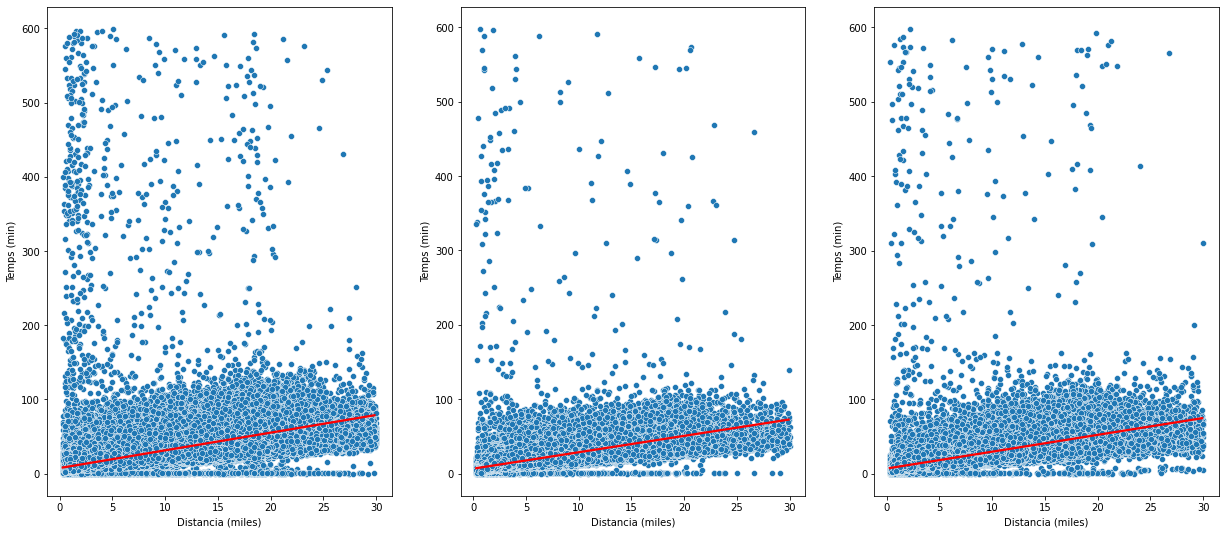

In [37]:
scatter_plot(df, 'trip_distance', 'trip_duration', 'Distancia (miles)', 'Temps (min)')

In [ ]:
2.41 

Year: 2019, y = 8.11 + 2.41 x
Year: 2020, y = 7.28 + 2.19 x
Year: 2021, y = 7.45 + 2.28 x


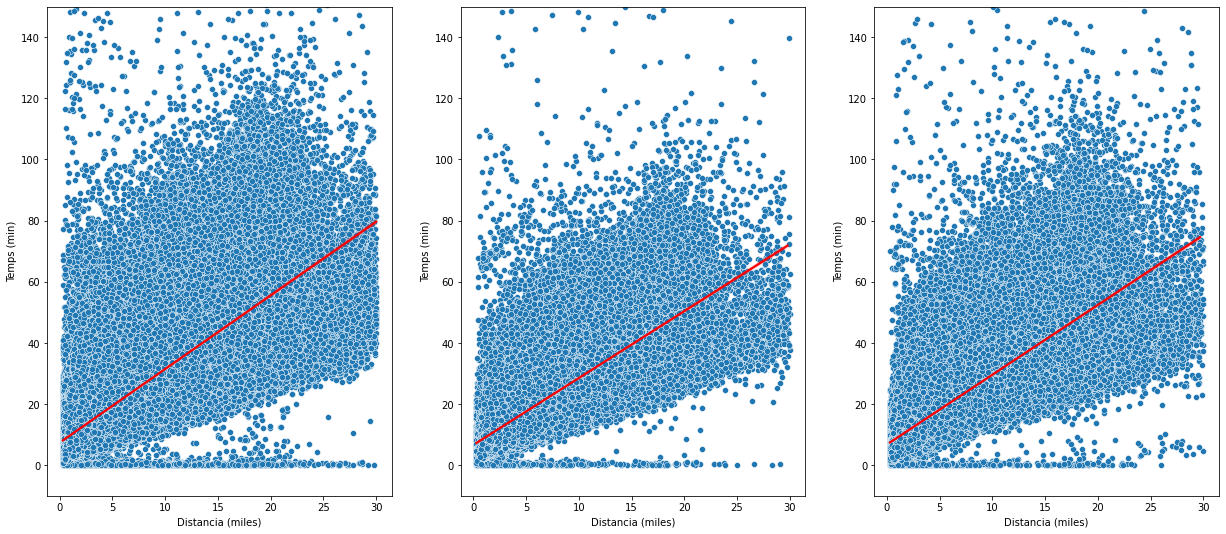

In [38]:
scatter_plot(df, 'trip_distance', 'trip_duration', 'Distancia (miles)', 'Temps (min)', True)

**Pregunta: Pots veure alguna relació? Pots calcular la correlació entre les dades per treure més informació?**

> ANSWER
> Sí, clarament hi ha una forta relació lineal entre la x i la y. En el 2019 el pendent de la regressió lineal és molt més fort (aprox 2.4), el que significa que els taxis tarden bastant més temps en recórrer la mateixa distància. De fet, que el pendent en l'any 2019 de la regressió lineal sigui 2.4 i en el 2020 sigui 2.2 es pot interpretar com que el taxis van aproximadament un 10% més lent en el 2019 que en el 2020, probablement perquè hi havia molt més tràfic. El 2021 torna a augemntar lleugerament (i significa que disminueix la velocitat), però no torna a nivells tan tant alts com el 2019.

Tal com fèiem a l'apartat 3, visualitzeu les dades temporals i de distància a partir de les setmanes, i mesos de l'any.

In [1]:
def visualize_per_period(df, column, columns, xlabel, ylabel, title):
    """
    Funció que visualitza la distància / duració dels trajectes en un temps a determinar
    """
    
    '''
    Per les mateixes raons que a l'apartat 3, només utilitzarem
    la pickup_hour. Aquí, però, volem obtenim la mitjana d'hores
    o milles dels viatjes i per tant utilitzarem la funció de mitjana.
    '''
    data = df.groupby(columns[0])[column].mean()

    # Creem la figura on hi haurà el gràfic i establim el tamany
    plt.figure(figsize=(21, 6))

    # Posem el títol i les etiquetes
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Creem el gràfic amb els paràmetres desitjats
    plt.plot(data.index, data, marker='o', linestyle='dashed')

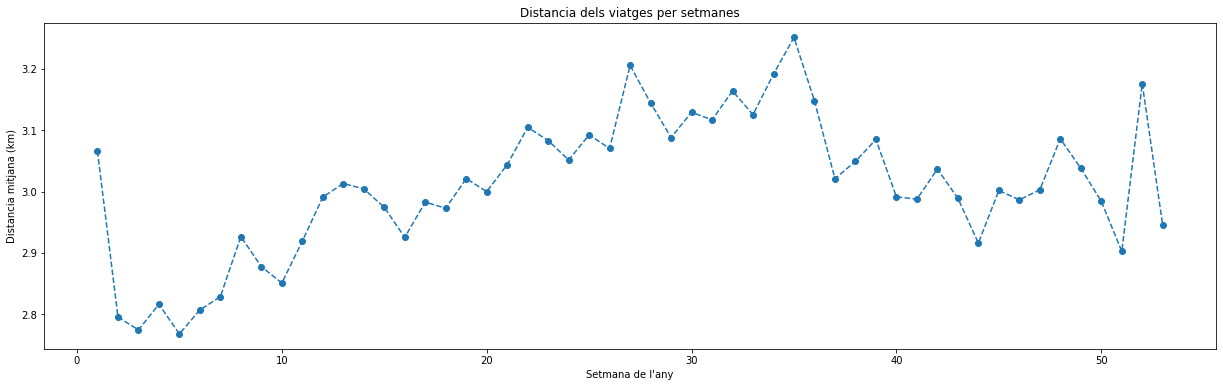

In [41]:
visualize_per_period(df, 'trip_distance', columns = ['pickup_week', 'dropoff_week'],
                    xlabel = 'Setmana de l\'any', ylabel = 'Distancia mitjana (miles)', title = 'Distancia dels viatges per setmanes')

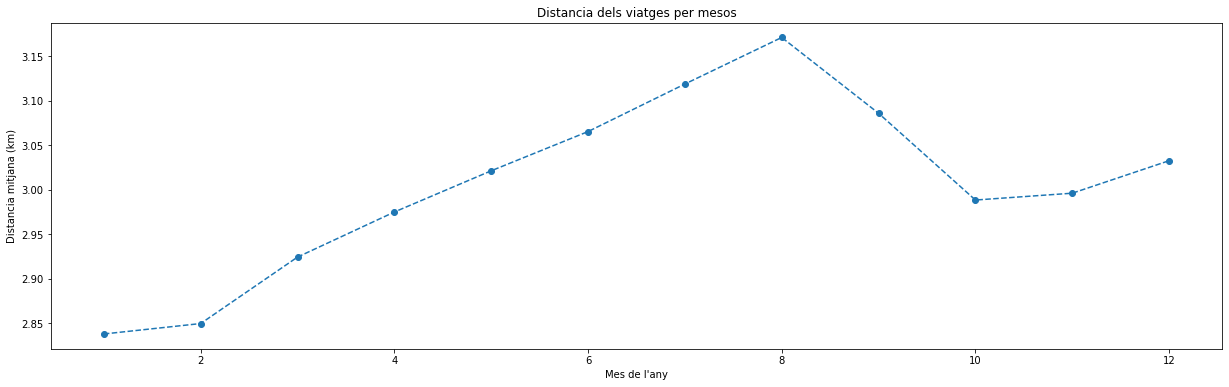

In [42]:
visualize_per_period(df, 'trip_distance', columns = ['pickup_month', 'dropoff_month'],
                     xlabel = 'Mes de l\'any', ylabel = 'Distancia mitjana (miles)', title = 'Distancia dels viatges per mesos')

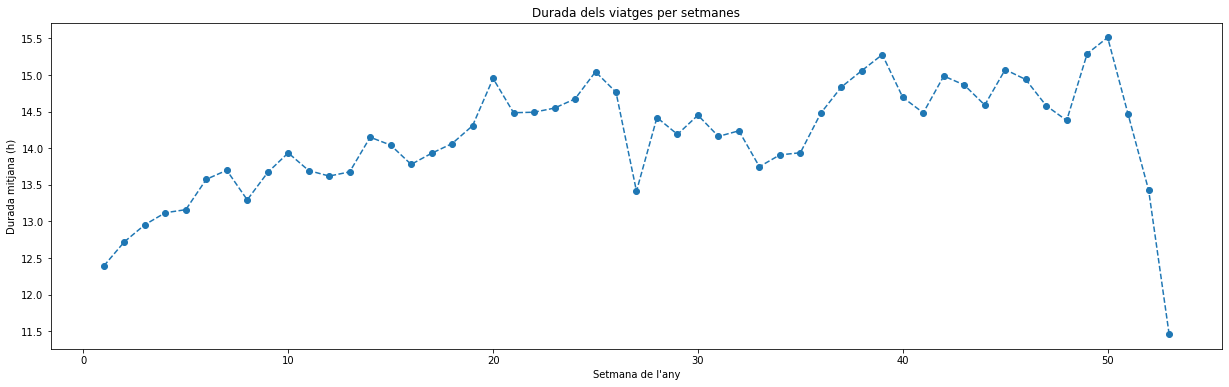

In [43]:
visualize_per_period(df, 'trip_duration', columns = ['pickup_week', 'dropoff_week'],
                     xlabel = 'Setmana de l\'any', ylabel = 'Durada mitjana (min)', title = 'Durada dels viatges per setmanes')

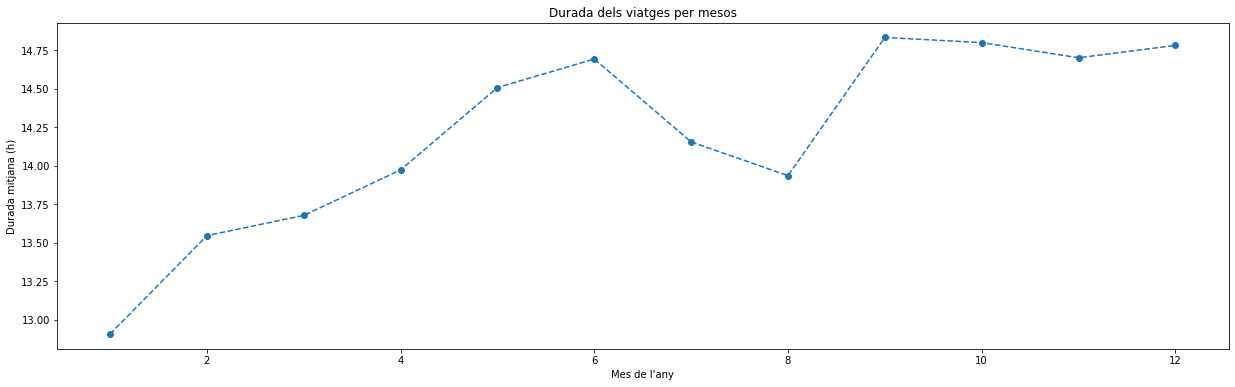

In [44]:
visualize_per_period(df, 'trip_duration', columns = ['pickup_month', 'dropoff_month'],
                     xlabel = 'Mes de l\'any', ylabel = 'Durada mitjana (min)', title = 'Durada dels viatges per mesos')

**Pregunta: Hi ha algun comportament estrany a part de la covid? Per què pot ser causat?**
    
> ANSWER Pel que fa a les distàncies, com el rang de mitjanes està en una amplitud d'uns 400 metres, és difícil extreure informació del gràfic de les setmanes, ja que està plena de pics. En la de mesos, però, es pot veure una tendència de distàncies més llargues cap als mesos de primavera/estiu. Potser a l'estiu s'utilitza el taxi per a viatges més llargs degut al calor, però és complicat determinar exactament per què es dona.
Pel que fa a les durades, passa el mateix que amb les distàncies en el gràfic setmanal. És complicat extreure informació degut a la petita amplitud del rang de valors i a la gran quantitat de pics. El més extrany es dona en la de viatges per mesos, on, comparant amb la gràfica de distàncies, podem veure que fins al Juny més o menys creixen de la mateixa manera, però a partir d'aquest mes, els dos pics són 'oposats'. És a dir, mentre que en el gràfic de distàncies a l'estiu les distàncies són les més grans, en el de durades es veu un mínim local (distància creix, durada decreix) i quan arribem a la tardor passa a l'inrevés, les distàncies disminueixen però les durades augmenten. Una raó pot ser que durant aquestes dates el trànsit es molt gran, independentment del covid. Però això es suposar massa, i és estrany imaginar que a l'estiu no hi hagi trànsit (excepte els anys de covid). Per tant, a part de la covid no se'ns acudeix una raó prou convincent que descrigui el que passa.

Fins ara hem mostrat les dades de manera agregada.

Per tal de visualitzar-ho de manera global, utilitzarem la funció *plt.imshow()* que visualitza imatges i, per tant, matrius.

Implementa una funció que visualitzi per any:

- un mapa de calor que indiqui a quina hora del dia hi ha viatges més llargs durant l'any.
- un mapa de calor que indiqui a quina hora del dia hi ha viatges més llargs durant la setmana.

In [4]:
def heatmap(df, group, column_data, xlabel, ylabel, columns=None):
    """
    Funció que agrega les dades de manera adient per visualitzar un mapa de calor
    """

    # Creem la figura on aniran els 3 histogrames (un per any)
    if group[1] == 'pickup_dayofyear':
        fig, axs = plt.subplots(nrows=3, figsize=(21, 6))
    else:
        fig, axs = plt.subplots(nrows=3, figsize=(16, 16))

    # Iterem pels 3 anys
    for i, year in enumerate(YEARS):

        # Agafem del dataframe les dades de l'any de la iteració actual
        df_year = df[df['year']==year]

        # Agrupem pel grup indicat i fem mitjana de les durades/distàncies dels viatges
        data = df_year.groupby(group)[column_data].mean()

        # Creem la matriu que mostrarem i fem un bucle per posar els elements agrupats anteriorment
        matrix = np.zeros((df_year[group[0]].nunique(), df_year[group[1]].nunique()))
        for idx, val in data.iteritems():
            matrix[idx[0], idx[1]-1] = val

        # Creem els mapes de calor, ajustant les escales en funció de si és durada o distància
        if column_data == 'trip_duration':
            c = axs[i].imshow(matrix, cmap='coolwarm', vmin=5, vmax=20)
        else:
            c = axs[i].imshow(matrix, cmap='coolwarm', vmin=2, vmax=6)

        # Posem les labels
        axs[i].set(xlabel=xlabel)
        axs[i].set(ylabel=ylabel)

        # Afegim una llegenda per a entendre millor el gràfic
        fig.colorbar(c, ax=axs[i])

        # En el cas de díes de la setmana canviem canviarem la label de l'eix y pels noms dels dies
        if columns:
            axs[i].set_yticks(range(7), columns)

2019 7.66880341880342 23.922744360902254
2020 1.3666666666666667 41.900000000000006
2021 1.7583333333333333 35.63333333333333


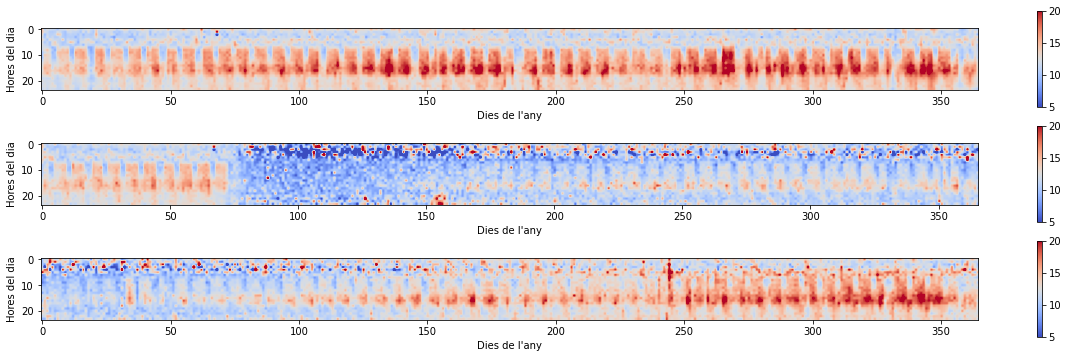

In [73]:
heatmap(df, ['pickup_hour', 'pickup_dayofyear'], 'trip_duration', 'Dies de l\'any', 'Hores del dia')

2019 10.379311039484287 19.157999376183103
2020 9.251412824095636 15.314945241691843
2021 10.563712461728878 17.517202690817467


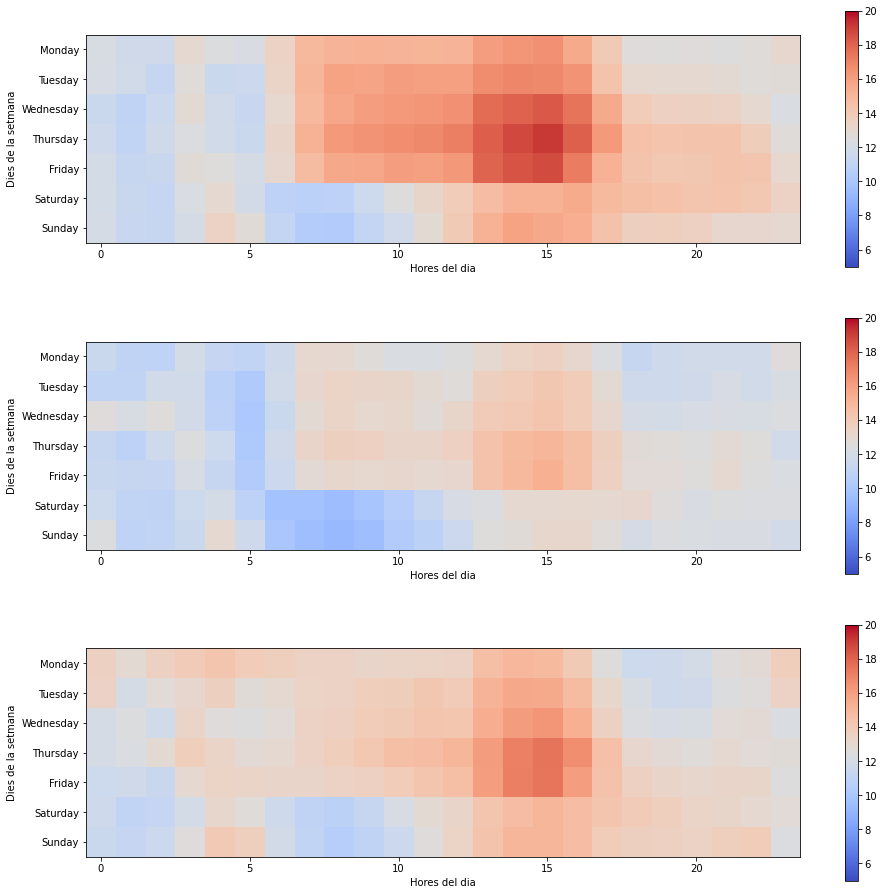

In [77]:
heatmap(df, ['pickup_day', 'pickup_hour'], 'trip_duration', 'Hores del dia', 'Dies de la setmana', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

Repeteix els gràfics anteriors visualitzant la distancia.

2019 2.0059285714285715 8.41268656716418
2020 0.3 20.9
2021 0.5349999999999999 24.16


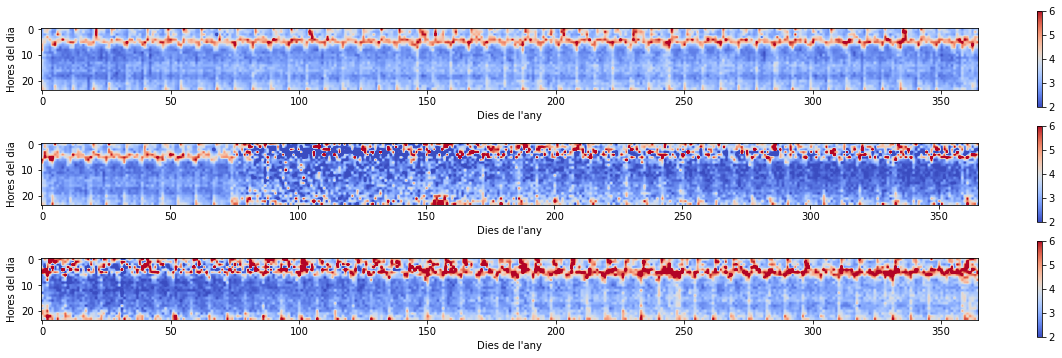

In [78]:
heatmap(df, ['pickup_hour', 'pickup_dayofyear'], 'trip_distance', 'Dies de l\'any', 'Hores del dia')

2019 2.520573851069059 5.658354846874209
2020 2.287956339038639 5.506332547169811
2021 2.5144183352639415 6.429837685250529


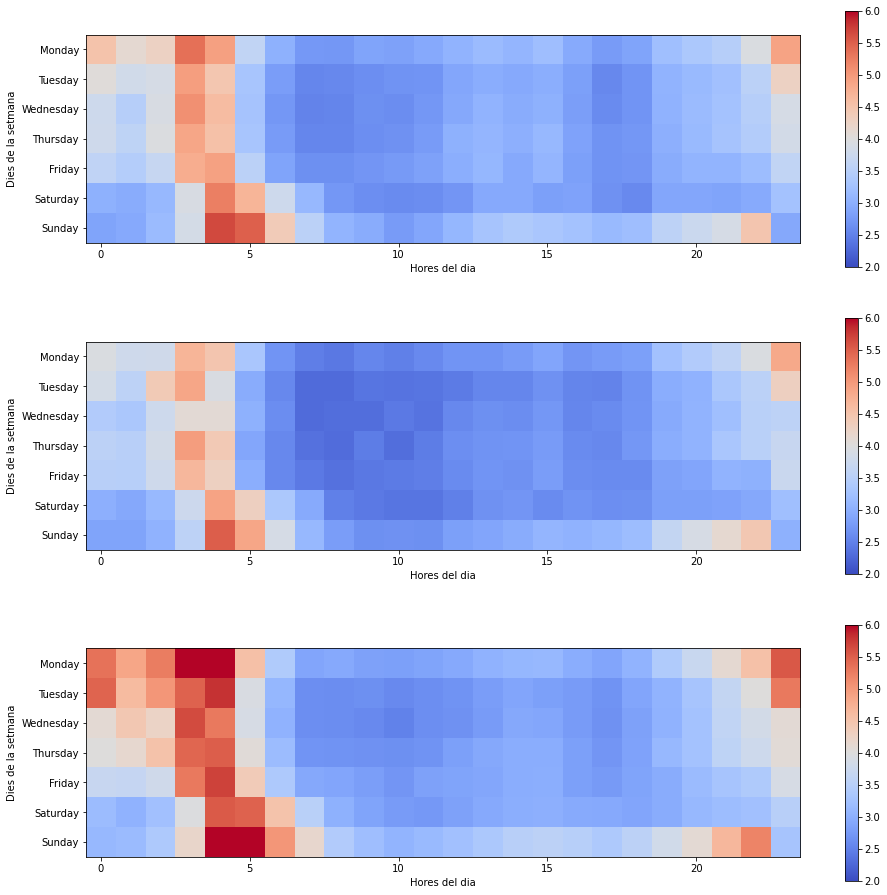

In [80]:
heatmap(df, ['pickup_day', 'pickup_hour'], 'trip_distance', 'Hores del dia', 'Dies de la setmana', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

Per últim, visualitza la velocitat mitjana a les diferents hores del dia durant la setmana.

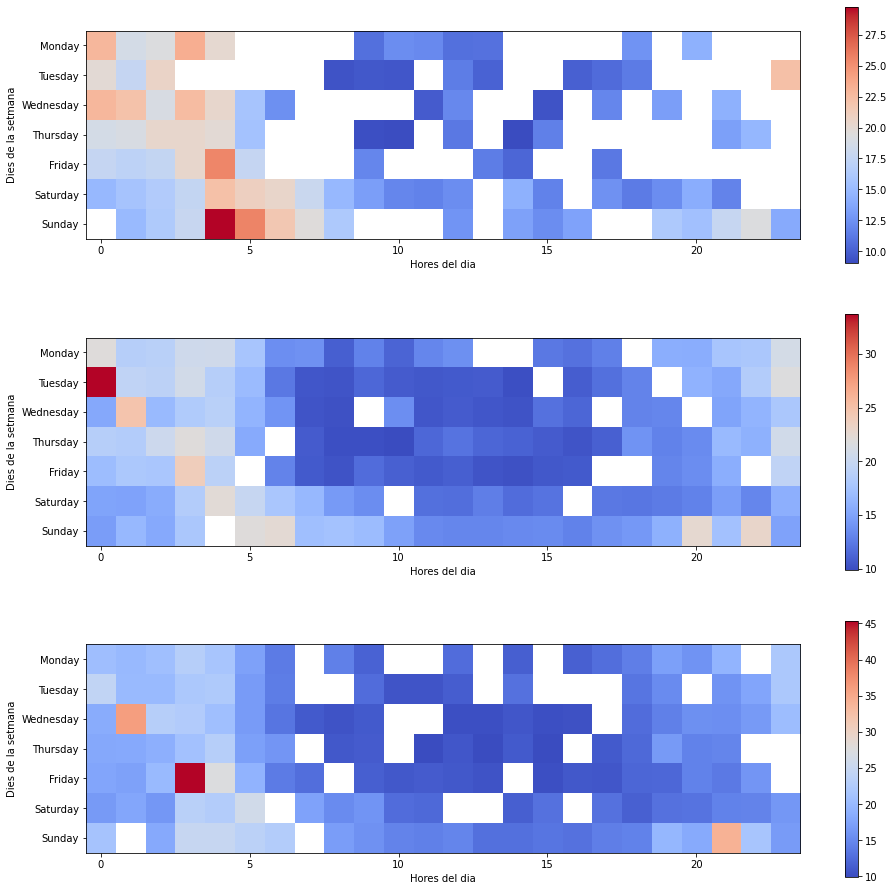

In [5]:
speed_heatmap(df, ['pickup_day', 'pickup_hour'], 'speed', 'Hores del dia', 'Dies de la setmana', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

**Pregunta: Quines conclusions treieu dels mapes de calor?**
    
> ANSWER

## 05. Visualitzem les localitzacions dels viatges

In [4]:
df.head()

tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
6078366  2019-01-25 21:29:14   2019-01-25 21:45:11              5.0   
5166095  2019-01-22 15:55:20   2019-01-22 16:05:13              1.0   
2945630  2019-01-13 13:26:00   2019-01-13 13:39:37              1.0   
6288004  2019-01-26 17:31:08   2019-01-26 18:04:26              1.0   
3837165  2019-01-16 22:39:52   2019-01-16 22:44:47              1.0   

         trip_distance  PULocationID  DOLocationID  payment_type  fare_amount  \
6078366           8.10           138           107             1         23.5   
5166095           1.77           125           234             1          9.0   
2945630           3.00           264           264             1         12.0   
6288004          10.99           132            82             2         32.5   
3837165           0.80            48           100             1          5.5   

         total_amount  year  month year-month  pickup_hour  pickup_day  \
6078366         35.61  2019      1    2019-01           21           4   
5166095         12.74  2019      1    2019-01           15           1   
2945630         15.36  2019      1    2019-01           13           6   
6288004         33.30  2019      1    2019-01           17           5   
3837165          7.80  2019      1    2019-01           22           2   

         pickup_week  pickup_month  pickup_dayofyear  trip_duration  
6078366            4             1                25      15.950000  
5166095            4             1                22       9.883333  
2945630            2             1                13      13.616667  
6288004            4             1                26      33.300000  
3837165            3             1                16       4.916667

Només tenim la ID d'una localització, per tant, necessitem aconseguir la latitud i la longitud.

La mateixa pàgina dels taxis ens dóna el fitxer *taxi_zones.zip*, però primer cal que convertim les dades de coordenades amb format WGS84.

Podem utilitzar aquesta web: https://mygeodata.cloud/

In [5]:
from utils import get_lat_lon, draw_region_map, draw_zone_map

In [6]:
sf = shapefile.Reader('data/geodata/taxi_zones.shp')

fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

In [92]:
'''
Hem notat que 'df_loc' conté duplicats i per tant els hem hagut d'eliminar. Ens hem quedat amb
l'úlitma aparició de la LocationID del dataframe, interpretant que és la última actualització de la dada 
'''

df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf, shp_dic).set_index("LocationID"), on="LocationID").drop_duplicates('LocationID', keep='last')
df_loc.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough  longitude   latitude  
0            EWR -74.171533  40.689483  
1         Queens -73.822478  40.610824  
2          Bronx -73.844953  40.865747  
3      Manhattan -73.977725  40.724137  
4  Staten Island -74.187558  40.550664

c:\Users\Andreu Vall\AppData\Local\Programs\Python\Python310\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


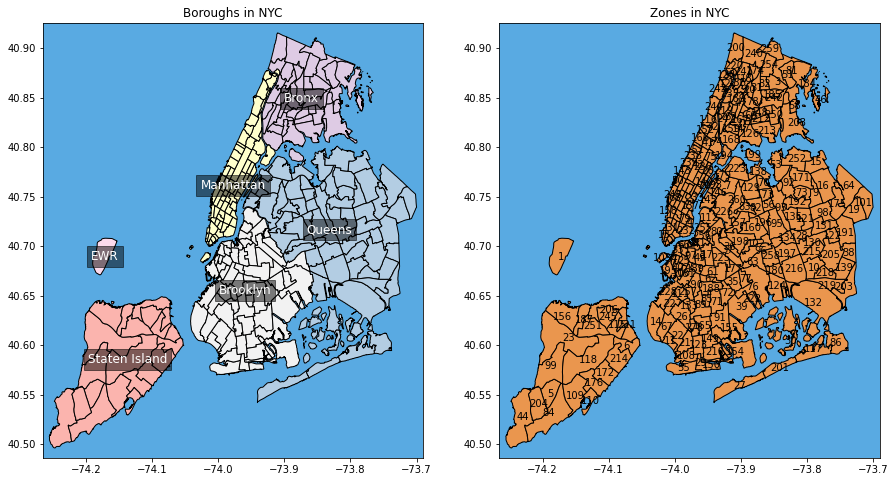

In [94]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, sf, shp_dic)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf, shp_dic)

Ara teniu dos dataframe que necessitem unir. Utilitza la funció *merge* per afegir la longitud i latitud al dataframe *df*:

In [95]:
# Aquí llistem les columnes que ens interessen de 'df_loc'
df_loc_reduced = df_loc[['LocationID', 'longitude', 'latitude']]

# Fem un primer merge per la columna PULocation
merge_tmp = pd.merge(df, df_loc_reduced, left_on='PULocationID', right_on='LocationID')
# Canviem els noms per a indicar que representen els pickups
merge_tmp.rename(columns={'longitude': 'pickup_longitude', 'latitude': 'pickup_latitude'}, inplace=True)
# Eliminem la columna LocationID que queda residual
merge_tmp.drop(columns='LocationID', inplace=True)

# Amb el merge anterior fem un segon merge per la columna DOLocation seguint el mateix procediment
merge = pd.merge(merge_tmp, df_loc_reduced, left_on='DOLocationID', right_on='LocationID')
merge.rename(columns={'longitude': 'dropoff_longitude', 'latitude': 'dropoff_latitude'}, inplace=True)
merge.drop(columns='LocationID', inplace=True)

In [96]:
merge.shape

(6496647, 22)

## 06. ¿Quines zones tenen més recollides i quines zones tenen més entregues?

En aquest apartat volem conèixer i visualitzar les zones on els taxis són més utilitzats.

El primer pas és ordenar i guardar en una variable els llocs més comuns en la recollida i el destí.

Printa els 5 llocs més freqüents per any en cada cas.

In [70]:
'''
Farem un groupby amb l'any i la LocationID corresponent, i per obtenir la quantitat de viatges
utilitzarem size. Tot seguit farem un reset_index i reanomenarem la columna on hi ha el nombre
de viatges a count i ordenarem aquesta en ordre de major a menor, per a una millor visualització
i tractament de les dades.
'''

# Recollida
top_pu = merge.groupby(['year', 'PULocationID']).size().reset_index().rename(columns={0: 'count'}).sort_values('count', ascending=False)

# Destí
top_do = merge.groupby(['year', 'DOLocationID']).size().reset_index().rename(columns={0: 'count'}).sort_values('count', ascending=False)

In [139]:
# Variable per establir el nombre de llocs usuals que voldrem mostrar al top
n_top = 5
def show_top_n(df, column, df_loc, n_top = n_top):
    """
    Funció que mostra els llocs més usuals per any
    """
    # Com sempre, creem la figura i iterem sobre els anys per a mostrar els 3 gràfics
    fig, axs = plt.subplots(len(YEARS), 1, figsize=(10, 30))
    for i, year in enumerate(YEARS):

        # Agafem els primers n_top (5) elements de la llista ja ordenada en la anterior cel·la
        top_locations = set(df.loc[df['year']==year, column][:n_top].values)
        # I dibuixem el mapa amb la funció que se'ns ha donat utilitzant aqesta llista
        draw_zone_map(plt.subplot(len(YEARS), 1, i+1), sf, shp_dic, {loc: 1 for loc in top_locations}, text=list(top_locations))

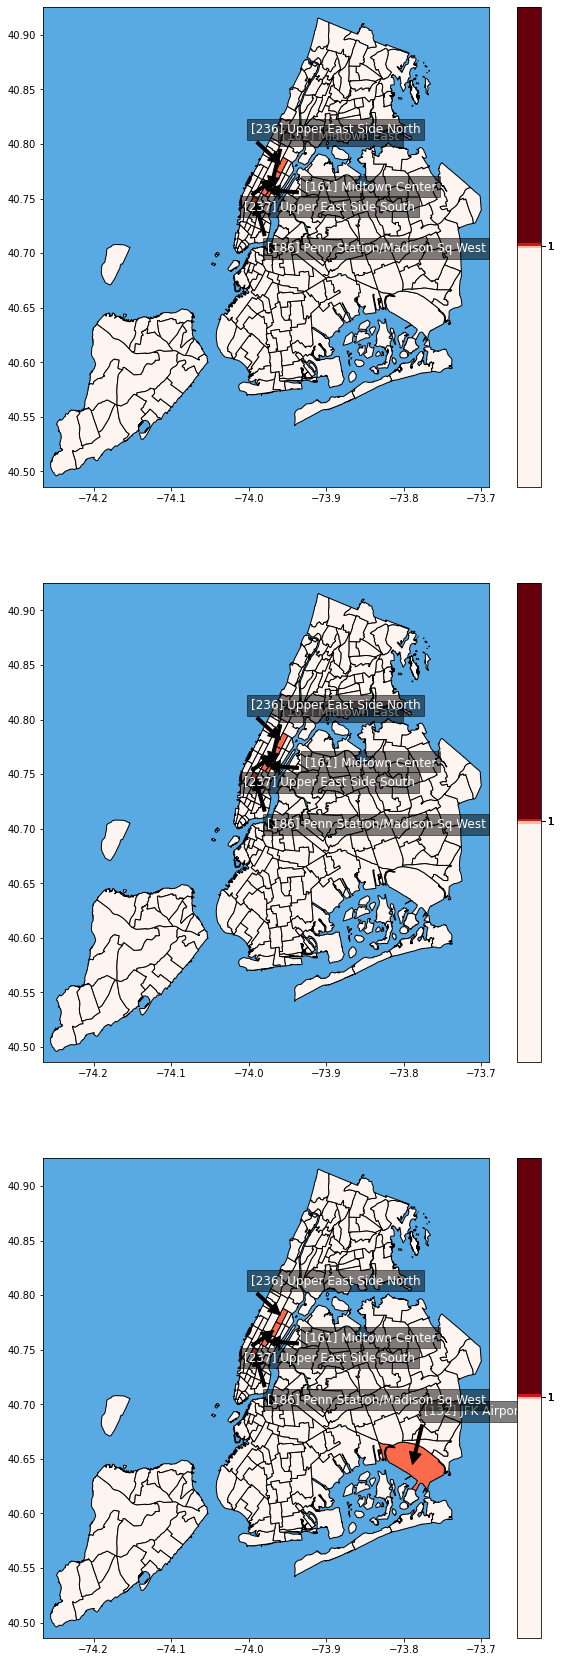

In [140]:
show_top_n(top_pu, 'PULocationID', df_loc)

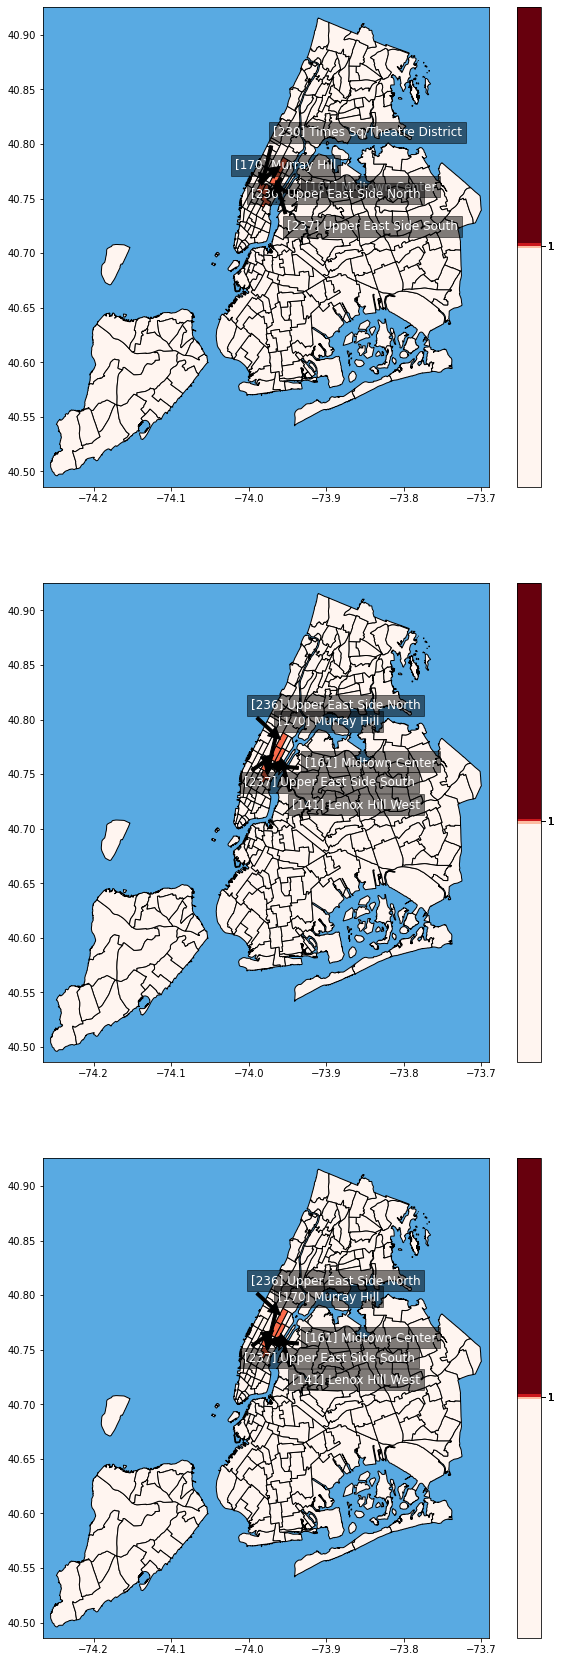

In [141]:
show_top_n(top_do, 'DOLocationID', df_loc)

**Visualitzem amb un mapa de calor quines són les zones més recurrents**

[237, 161, 236]
[237, 236, 161]
[237, 236, 161]


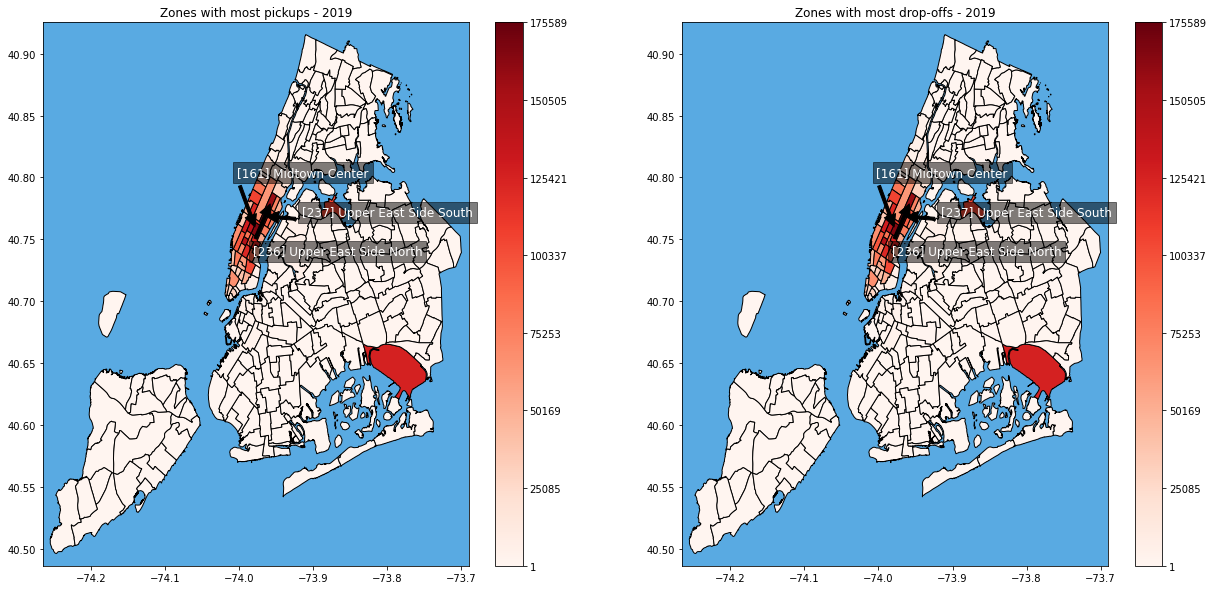

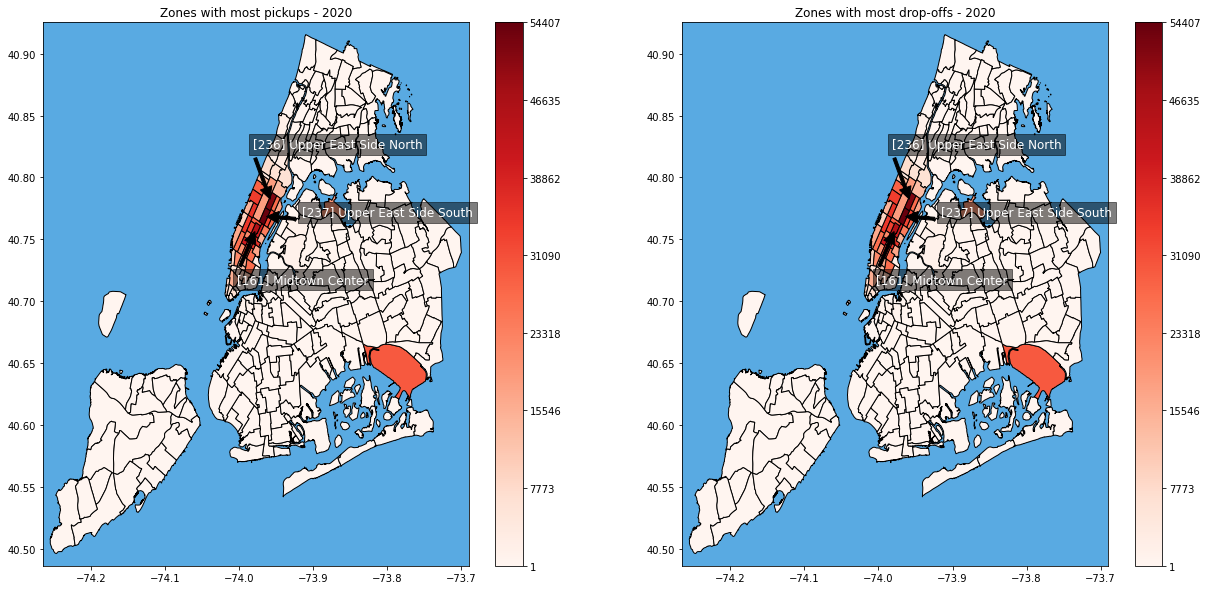

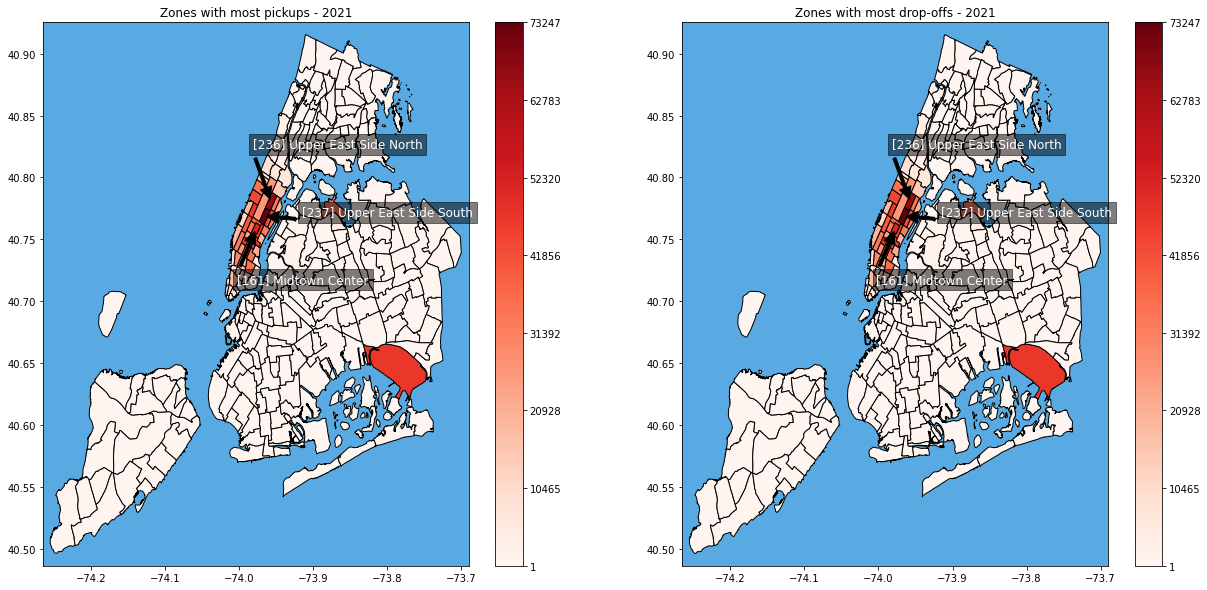

In [142]:
for year in YEARS:

    # Agafem les zones de recollida més recurrents
    tmp = top_pu[top_pu['year']==year]

    # Transformem la taula en un diccionari per utilitzar-ho al mètode
    PUcount = dict(zip(tmp['PULocationID'], tmp['count']))

    # Creem la figura on hi haurà els dos mapes (pickup i dropoff)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(21, 10))
    
    # Establim el tamany i el títol
    ax = plt.subplot(1, 2, 1)
    ax.set_title(f"Zones with most pickups - {year}")

    # Cridem el mètode per dibuixar el mapa
    draw_zone_map(ax, sf, shp_dic, heat=PUcount, text=list(PUcount.keys())[:3])
    
    # Repetim el procés per dropoff
    ax = plt.subplot(1, 2, 2)
    ax.set_title(f"Zones with most drop-offs - {year}")
    draw_zone_map(ax, sf, shp_dic, heat=PUcount, text=list(PUcount.keys())[:3])

**Pregunta: Per què creieu que la zona de Manhattan té més quantitat de viatges?**
> ANSWER Fent una cerca a Google hem trobat que la zona de Manhattan és la zona de NYC que té més densitat de població i a més la zona amb més quantitat de persones de classe alta. A més, és la zona de NYC que on hi ha més empreses amb la seva sede allà. Per tant, té força sentit, amb aquests fets, que sigui la zona on més viatges de taxi hi ha, tant de recollida com de destinació.

## 07. Hospitals

Com ha canviat la destinació dels viatges? Hi ha més gent que va als hospitals?

A la següent cel·la us donem la creació manual d'un DataFrame amb la localització més important dels hospitals de Nova York.

In [147]:
hospitals = [('New York’s Presbyterian Lower Manhattan Hospital, NYC, NY, USA', '40.710255', '-74.005058'),
('Manhattan Gastroenterology, NYC, NY, USA', '40.778259', '-73.958092'),
('Stem Cell Therapy Hospital, NYC, NY, USA', '40.601517', '-73.961067'),
('Park Avenue Smiles, Yonkers, NYC, NY, USA', '40.945873', '-73.890671'),
('Cosmetic Dentistry Center, NYC, NY, USA', '40.629234', '-74.026077'),
('Envy Smile Dental Spa, Brooklyn, NYC, NY, USA', '40.607059', '-73.960144'),
('VIVA EVE, Forest Hills, NYC, NY, USA', '40.734291', '-73.849434'),
('Forest Hills Medical Services, Queens, NYC, NY, USA', '40.734310', '-73.849510'),
('Professional Gynecological Services, Brooklyn, NY, NY, USA', '40.689747', '-73.982346'),
('Manhattan Womens Health & Wellness, New York, NY, USA', '40.741997', '-73.986107'),
('Brooklyn Abortion Clinic, Brooklyn, NY, New York, USA', '40.689743', '-73.982368'),
('Brooklyn GYN Place, Brooklyn, NY, USA', '40.692696', '-73.993584'),
('Americas Holistic Doctor, NYC, NY, USA', '40.742531', '-73.985489'),
('NJS Physical Medicine & Rehabilitation, Brooklyn, NY, USA', '40.641621', '-73.956734'),
('DHD Medical, Brooklyn New York, USA', '40.625568', '-73.918320'),
('Workers Compensation Doctor, New York, NY, USA', '40.652225', '-74.006104'),]

hospitals = pd.DataFrame(hospitals, columns = ['Place Name', 'Latitude', 'Longitude'])
hospitals['Latitude'] = hospitals['Latitude'].astype(float)
hospitals['Longitude'] = hospitals['Longitude'].astype(float)
hospitals.head()

Place Name   Latitude  Longitude
0  New York’s Presbyterian Lower Manhattan Hospit...  40.710255 -74.005058
1           Manhattan Gastroenterology, NYC, NY, USA  40.778259 -73.958092
2           Stem Cell Therapy Hospital, NYC, NY, USA  40.601517 -73.961067
3          Park Avenue Smiles, Yonkers, NYC, NY, USA  40.945873 -73.890671
4            Cosmetic Dentistry Center, NYC, NY, USA  40.629234 -74.026077

Utilitza la latitud i longitud de cada hospital i la de les zones del dataframe *merge* per veure la distribució dels hospitals.

Per fer-ho utilitza els gràfics de dispersió. Recorda que s'entendrà millor si els punts són transparents (paràmetre *alpha*).

Després repeteix el mateix gràfic però separat per any. 

In [164]:
def scatter_locations(merge, hospitals):
    """Funció que mostra la distribució dels hospitals i les destinacions dels taxis"""

    # Creem la figura per al gràfic de dispersió
    plt.figure(figsize=(16, 8))

    # Primer posarem els punts dels hospitals
    plt.scatter(x=hospitals['Longitude'], y=hospitals['Latitude'], label='Hospitals')
    # Tot seguit posarem els punts de les zones dels viatges
    '''
    Utilitzant el paràmetre alpha, essencialment el que veiem és que els punts
    amb més transparència són els que han tingut menys destinacions (utilitzarem
    destinacions degut a que pensem que es el que te més rellevància de cara a 
    veure viatges a l'hospital)
    '''
    plt.scatter(x=merge['dropoff_longitude'], y=merge['dropoff_latitude'], alpha=0.005)
    plt.legend()

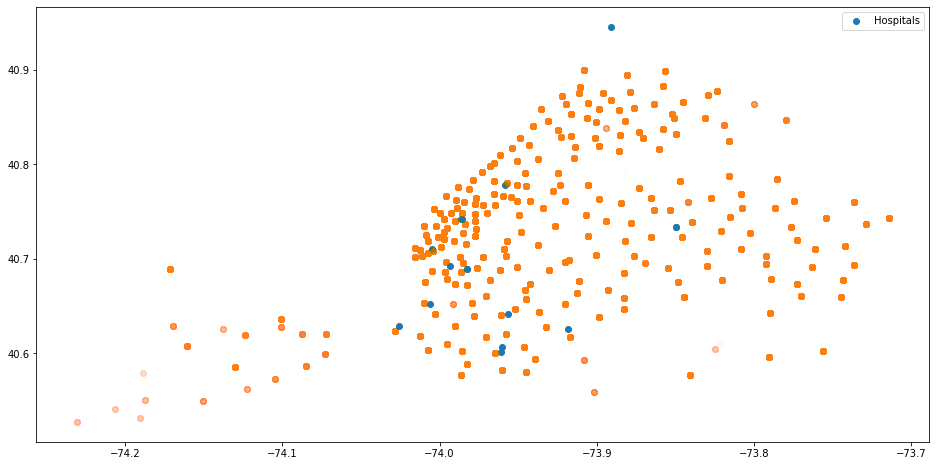

In [165]:
scatter_locations(merge, hospitals)

In [172]:
def scatter_locations_per_year(merge, hospitals):
    """Funció que mostra la distribució dels hospitals i les destinacions dels taxis"""

    # Farem el mateix que a la cel·la anterior iterant i mostrany per anys com hem fet sempre

    fig, axs = plt.subplots(nrows=len(YEARS), figsize=(10, 30))
    for i, year in enumerate(YEARS):
        axs[i].scatter(x=hospitals['Longitude'], y=hospitals['Latitude'])
        axs[i].scatter(x=merge.loc[merge['year']==year, 'dropoff_longitude'], y=merge.loc[merge['year']==year, 'dropoff_latitude'], alpha=0.002)

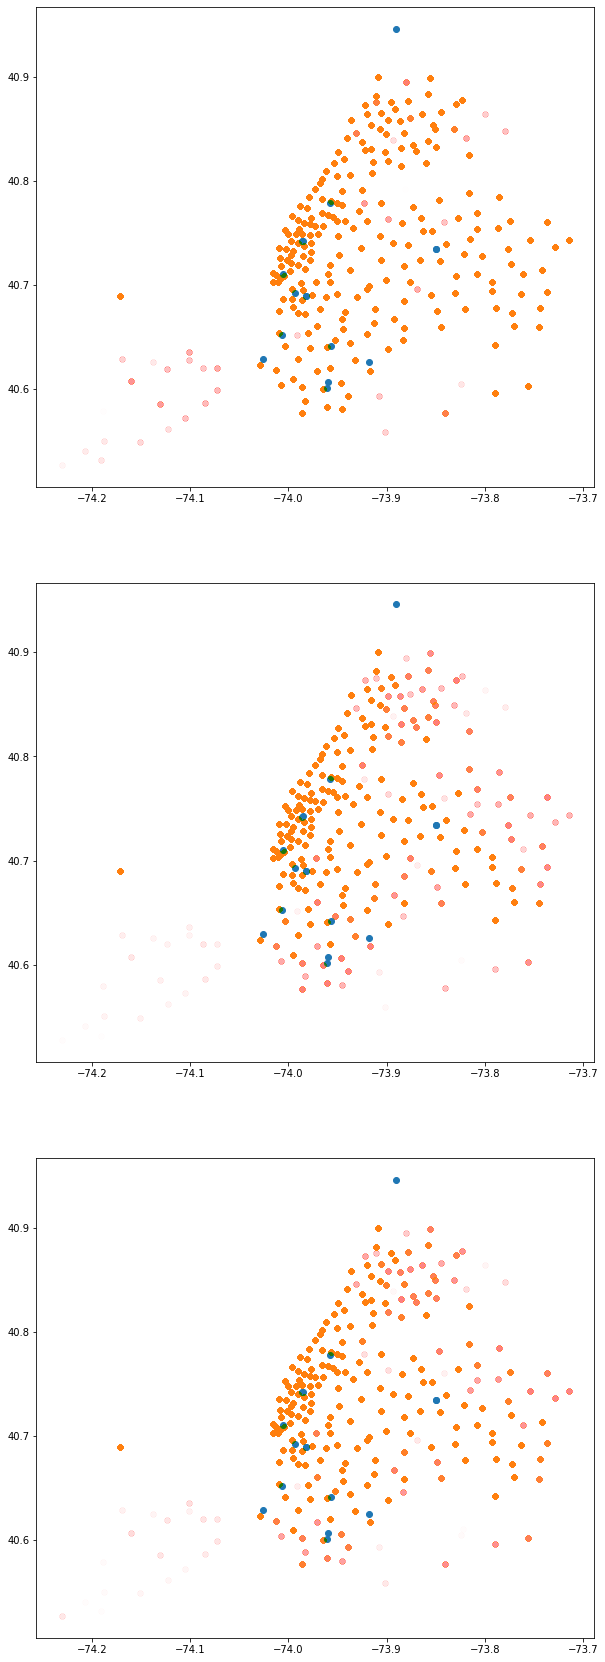

In [173]:
scatter_locations_per_year(merge, hospitals)

**Pregunta: Veus algun comportament?**
>ANSWER Tot i que no s'aprecia molt, hi ha una lleugera disminució dels viatges en les zones allunyades de Manhattan. Encara que posem l'alpha molt petit, al haver múltiples viatges a la mateixa zona acaba sent color sòlid i costa trobar un valor en el que podem apreciar de manera precisa un canvi en el comportament.

Per poder conèixer com ha variat els trajectes als hospitals, primer cal detectar a quina localització del mapa pertany cada hospital.

Per fer això cal calcular les distàncies. No calculeu la distància punt a punt, sinó matricialment.

In [174]:
from scipy.spatial import distance_matrix

In [181]:
hospitals_loc = hospitals[['Longitude', 'Latitude']].values
loc = df_loc[['longitude', 'latitude']].values

# Apliquem la funció als dos dataframes anterior  
dist = distance_matrix(hospitals_loc, loc)

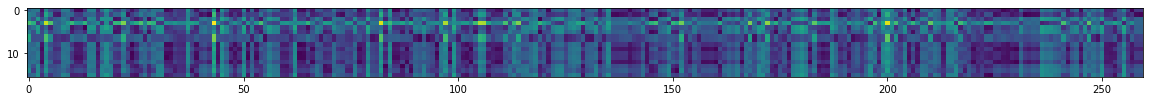

In [182]:
plt.figure(figsize=(20, 5))
plt.imshow(dist)

Trobeu la manera de localitzar el sector més proper a partir de les distàncies.

In [198]:
# Iterem sobre els valors mínims de cada fila de la matriu de distàncies
hospitals_locations = [df_loc.iloc[val]['LocationID'] for val in np.argmin(dist, axis=1)]

# Afregim com a nova columna les IDs calculades
hospitals['LocationID'] = hospitals_locations

In [199]:
hospitals.head()

Place Name   Latitude  Longitude  \
0  New York’s Presbyterian Lower Manhattan Hospit...  40.710255 -74.005058   
1           Manhattan Gastroenterology, NYC, NY, USA  40.778259 -73.958092   
2           Stem Cell Therapy Hospital, NYC, NY, USA  40.601517 -73.961067   
3          Park Avenue Smiles, Yonkers, NYC, NY, USA  40.945873 -73.890671   
4            Cosmetic Dentistry Center, NYC, NY, USA  40.629234 -74.026077   

   LocationID  
0         209  
1         236  
2         123  
3         200  
4          14

Ara que ja tenim en quin sector es troben els hospitals, visualitzeu quants trajectes hi ha relacionats amb ells.

Suposarem que tots els trajectes al sector van a l'hospital.

Feu una única figura amb dos gràfics de barres on es mostrin la quantitat de viatges per cada any i el % del total dels viatges.

In [260]:
def trips_hospitals(df, hospitals_locations):
    """
    Funció que mostra una única figura amb dos gràfics de barres on es mostrin la quantitat de viatges per cada any i el % del total dels viatges.
    """

    # Creem la figura on tindrem els 6 gràfics
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(21, 10))

    # Variables per a escalar els gràfics
    height_max, perc_max = 0, 0

    # Iterem sobre els anys
    for i, year in enumerate(YEARS):

        # Guardem els nombres de viatges per zona
        height = df.loc[df['year']==year, 'DOLocationID'].value_counts()[hospitals_locations]

        # Guardem també els percentatges
        percentage = 100 * height / (df['year']==year).sum()

        # Actualitzem els màxims per escalar al final
        height_max = max(height_max, height.max())
        perc_max = max(perc_max, percentage.max())

        # Creem els gràfics de barres per tant per a nombre de viatges com percentatges
        axs[0, i].bar(x=[str(hos) for hos in hospitals_locations], height=height)
        axs[1, i].bar(x=[str(hos) for hos in hospitals_locations], height=percentage)
    # Tornem a iterar per establir els y_lims i així escalar els gràfics
    for i in range(len(YEARS)):
        axs[0, i].set(ylim=(0, height_max))
        axs[1, i].set(ylim=(0, perc_max))

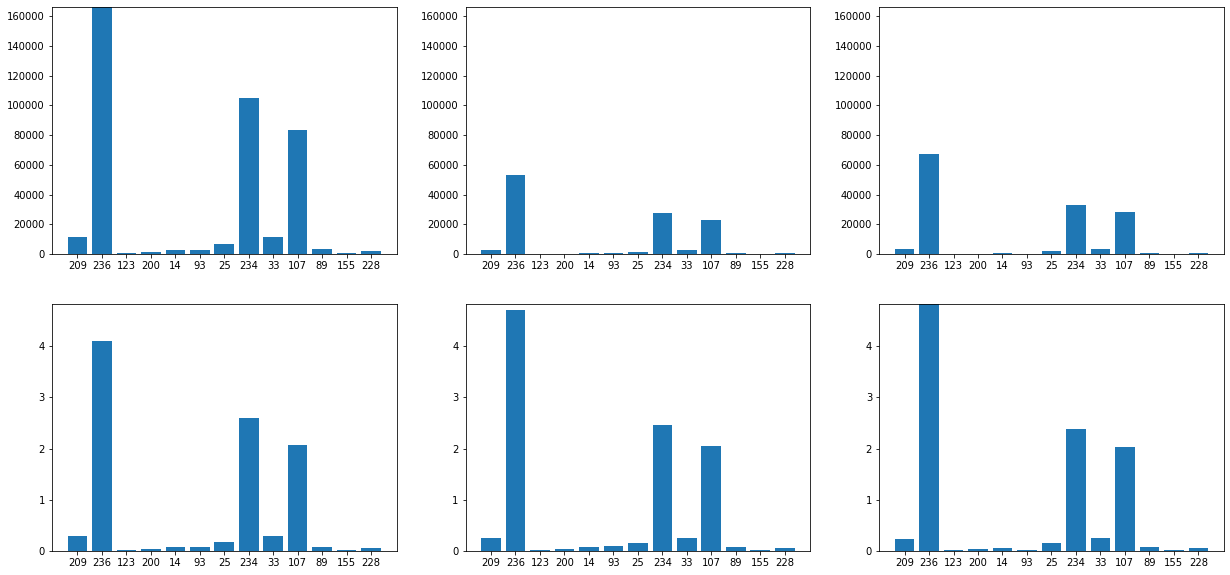

In [261]:
trips_hospitals(df, hospitals_locations)

## 08. Qui escolta pels forats, sent els seus pecats

A la **primera part** heu de visualitzar i comentar els exemples que hem eliminat, com distancies molt llargues, molt curtes...

A la **segona part** teniu llibertat per escollir i fer visualitzacions que us aportin informació extra que no s'hagi vist anteriorment.

In [ ]:
'''

'''

## 09. Informe

A partir de l'exploració de les dades que heu fet al llarg d'aquest notebook, feu un petit informe resumint i justificant tots els canvis que han sorgit a causa de la covid.

Llistarem a continuació els canvis en el servei de taxis de New York City degut a la covid:

- El nombre de viatges s'han reduit immensament (al voltant d'un 75%). De fet, aquest canvi es veu clarament degut a l'estat de confinament del 3 de Març de 2020, on podem veure la disminució abrupta del nombre de viatges. Podem apreciar també la lenta recuperació de l'estat normal amb el pas dels mesos l'any següent.

- La velocitat dels trajectes han augmentat lleugerament, probablement degut a la reducció de densitat en el tràfic (la propia disminució del nombre de trajectes demostra aquesta reducció en el tràfic).

- Durant el 2021, va haver un nombre considerable de recollides a l'aeropot JFK. Això pot donar a entendre que un cop es van reobrir les fronteres a 2021, va haver molta gent que agafava el taxi a l'aeroport, i potser destaca respecte a la resta ja que en la resta de zones seguía havent una gran reducció en el nombre de viatges.

- El nombre de viatges cap als hospitals més grans (Manhattan) va augmentar (almenys en percentatge) durant els anys de covid. Cal mencionar sobre aquesta part que la informació no es del tot fiable ja que estem assumint que un viatge a una zona on hi ha un hospital és un viatge a l'hospital, el que és clar que no és així. Per tant no podem confirmar que el covid hagi causat això al 100%

